In [2]:
import pandas as pd
import json
import os
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
)
from typing import List, Dict
import seaborn as sns
import matplotlib.pyplot as plt
from emoji import demojize
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
import pickle
import ast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-08-18 11:12:56.045485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 11:12:57.079152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def model_summary(model):
    print("Model summary:")
    print("---------------------------")
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
    print(f"Total parameters: {total_params}")
    
"""def print_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()"""

def normalizeToken(token):
        lowercased_token = token.lower()
        if token.startswith("@"):
            return "@USER"
        elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
            return "HTTPURL"
        elif len(token) == 1:
            return demojize(token)
        else:
            if token == "’":
                return "'"
            elif token == "…":
                return "..."
            else:
                return token

def normalizeTweet(tweet):
        tokens = TweetTokenizer().tokenize(tweet.replace("’", "'").replace("…", "..."))
        normTweet = " ".join([normalizeToken(token) for token in tokens])

        normTweet = (
            normTweet.replace("cannot ", "can not ")
                .replace("n't ", " n't ")
                .replace("n 't ", " n't ")
                .replace("ca n't", "can't")
                .replace("ai n't", "ain't")
        )
        normTweet = (
            normTweet.replace("'m ", " 'm ")
                .replace("'re ", " 're ")
                .replace("'s ", " 's ")
                .replace("'ll ", " 'll ")
                .replace("'d ", " 'd ")
                .replace("'ve ", " 've ")
        )
        normTweet = (
            normTweet.replace(" p . m .", "  p.m.")
                .replace(" p . m ", " p.m ")
                .replace(" a . m .", " a.m.")
                .replace(" a . m ", " a.m ")
        )
        return " ".join(normTweet.split())

class TweetDataset(Dataset):
    def __init__(self, x, y, mlb, tokenizer, fsl_strategy = None, binary = False):
        self.x = x
        self.y = y
        self.mlb = mlb
        self.tokenizer = tokenizer
        self.max_length = 128
        self.encoded_tweets = self.preprocess_text(self.x, fsl_strategy)
        self.binary = binary

    def preprocess_text(self, X, fsl_strategy):
        X = [normalizeTweet(tweet) for tweet in X]
        
        return self.tokenizer(X, return_attention_mask=True, return_tensors='pt', padding=True, truncation = True, max_length=self.max_length)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.binary:
            label = self.y[idx].item()  # Convert tensor to a single integer value
            return {
                'input_ids': self.encoded_tweets['input_ids'][idx],
                'attention_mask': self.encoded_tweets['attention_mask'][idx],
                'label': torch.tensor(label)
            }
        else:
            label = self.y[idx]
            #print(label)
            return {'input_ids': self.encoded_tweets['input_ids'][idx],
                    'attention_mask': self.encoded_tweets['attention_mask'][idx],
                    'label': torch.tensor(label, dtype=torch.float32)}
                    #'label_ids': self.labels[idx]}
        
class MultiLabelDataCollator(DataCollatorWithPadding):
    def __init__(self, tokenizer):
        super().__init__(tokenizer)

    def __call__(self, features: List[Dict[str, torch.Tensor]]):
        batch = super().__call__(features)
        batch["labels"] = torch.stack([feature["label"] for feature in features])
        return batch
    
def get_classification_report(data_loader, model, target_names, label_names):
    labels = []
    predictions = []
    for batch in data_loader:
        batch_inputs = {'input_ids': batch['input_ids'].to(device),
                        'attention_mask': batch['attention_mask'].to(device)}
        with torch.no_grad():
            logits = model(**batch_inputs).logits
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(torch.Tensor(logits))
        batch_predictions = (probs >= 0.5).detach().cpu().numpy().astype(int)
        predictions.append(batch_predictions)
        labels.append(batch['labels'].detach().cpu().numpy().astype(int))

    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis = 0)

    #cm = multilabel_confusion_matrix(labels, predictions)
    dict_report = classification_report(labels, predictions, target_names=target_names, labels=label_names, zero_division=0, output_dict=True)
    report = classification_report(labels, predictions, target_names=target_names, labels=label_names, zero_division=0)
    return dict_report, report
    
def calculate_average_report(reports):
    print(reports)
    print(len(reports))
    avg_report = {}
    for report in reports:
        for key, scores in report.items():
            if key not in avg_report:
                avg_report[key] = {}
                for score_key, score_value in scores.items():
                    avg_report[key][score_key] = score_value
            else:
                for score_key, score_value in scores.items():
                    avg_report[key][score_key] += score_value

    num_reports = len(reports)
    for key, scores in avg_report.items():
        for score_key in scores:
            avg_report[key][score_key] /= num_reports

    return avg_report

def average_report_to_dataframe(average_report):
    data = {
        "precision": [],
        "recall": [],
        "f1-score": [],
        "support": []
    }
    index = []

    for class_name, metrics in average_report.items():
        if class_name == 'accuracy':
            continue

        index.append(class_name)
        data["precision"].append(metrics["precision"])
        data["recall"].append(metrics["recall"])
        data["f1-score"].append(metrics["f1-score"])
        data["support"].append(metrics["support"])

    return pd.DataFrame(data, index=index)

def inject_weak_labels(train_df, weak_labels_df, fsl_strategy):
    co_occur_prob = None
    if fsl_strategy == 'distinct':
        for index, row in weak_labels_df.iterrows():
            annotations = ast.literal_eval(row['annotations'])
            #print(len(annotations))
            if len(annotations) == 1:
                train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
    """if fsl_strategy == 'co-occurrence':
        co_occur_prob = co_occurrence(train_df['annotations'])
        for index, row in weak_labels_df.iterrows():
            annotations = ast.literal_eval(row['annotations'])
            if len(annotations) == 1:
                train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'co-occurence': True}, ignore_index=True)"""

    """if fsl_strategy == 'eda':
        augmented_train_df = pd.DataFrame(columns=['text', 'annotations'])
        for index, row in train_df.iterrows():
            tweet_text = normalizeTweet(row['text'])
            augmented_tweets = eda.eda(tweet_text, alpha_sr=0.05, alpha_ri=0.05, alpha_rs=0.05, p_rd=0.5, num_aug=8)
            for augmented_tweet in augmented_tweets:
                augmented_train_df = augmented_train_df.append({'text': augmented_tweet, 'annotations': row['annotations']}, ignore_index=True)
        train_df = augmented_train_df"""
    
    return train_df, co_occur_prob

def get_embeddings_of_train_set(task, weak_labeled = True, fsl_strategy = None, weak_labels_path = None, output_dir = "../data/embedded/labeled_data.csv"):
    k = 1
    
    val_classification_reports = []
    test_classification_reports = []

    for fold in range(0,k):

        model_path = f"../models/{task}_epochs_200_train_size_full_fold_{fold}"
        
        latest_checkpoint = os.path.join(model_path, "")  # use "" for models that were manually saved after training. use sorted(checkpoint_files)[0] for the first automatically saved checkpoint 
        #print(latest_checkpoint)
        
        # Load the model and tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(latest_checkpoint)
        model.to(device)
        tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

        filename = f"../data/labeled_data/generic_test_{fold}.json"
        with open(filename) as f:
            data = json.load(f)
        train_df = pd.DataFrame(data["train"])

        if (fsl_strategy != 'none') and (weak_labels_path != None):
            weak_labels_df = pd.read_csv(weak_labels_path)
            train_df, co_occurrence_probabilities = inject_weak_labels(train_df, weak_labels_df, fsl_strategy)

        val_df = pd.DataFrame(data["valid"])
        test_df = pd.DataFrame(data["test"])
        df_all = pd.concat([train_df, val_df, test_df])
        df_all = df_all.reset_index(drop=True)
        
        import ast
        #print(train_df["annotations"])
        try:
            train_annotations = train_df["annotations"].apply(ast.literal_eval).tolist()
        except:
            train_annotations = train_df["annotations"].tolist()
        classes = set()
        for annotation in train_annotations:
            classes.update(annotation)
        classes = sorted(list(classes))

        checkpoint = torch.load(os.path.join(model_path, "pytorch_model.bin"))
        model.load_state_dict(checkpoint)
        model = model.base_model
        
        mlb = MultiLabelBinarizer(classes=classes)
        
        df_all_labels = mlb.fit_transform(df_all["annotations"])

        df_all_dataset = TweetDataset(df_all['text'].to_list(), torch.tensor(df_all_labels), mlb, tokenizer)
        
        BATCH_SIZE = 500
        df_all_loader = torch.utils.data.DataLoader(
            df_all_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=MultiLabelDataCollator(tokenizer)
        )
        
        model.eval()
        print(len(df_all_loader))
        df_all["embedding"] = np.NaN
        absolute_idx = 0
        for idx, tweet in enumerate(tqdm(df_all_loader)):
            tweet = {key: value.to(device) for key, value in tweet.items()}
            with torch.no_grad():  # Ensure no gradients are computed for this operation
                outputs = model(input_ids=tweet['input_ids'], attention_mask=tweet['attention_mask'])
                embeddings = outputs.last_hidden_state

            try:
                for i in range(BATCH_SIZE):
                    absolute_idx = idx * BATCH_SIZE + i
                    embedding_array = embeddings[i].cpu().numpy()
                    serialized_embedding = pickle.dumps(embedding_array)
                    df_all.loc[absolute_idx, "embeddings"] = serialized_embedding

            except IndexError as e:
                df_all.to_csv(output_dir)
                print("Error:", e)
        
        df_all.to_csv(output_dir)
    return df_all



def calculate_metrics(task, weak_labeled = True):
    k = 5
    
    val_classification_reports = []
    test_classification_reports = []

    # Loop over each fold and load the corresponding model
    for fold in range(k):
        if weak_labeled:
            model_path = f"../models/weak_labeled/{task}_epochs_200_train_size_full_fold_{fold}"
        else: 
            model_path = f"../models/{task}_epochs_200_train_size_full_fold_{fold}"
        # find the latest checkpoint file
        #checkpoint_files = [f for f in os.listdir(model_path) if f.startswith("checkpoint")]
        latest_checkpoint = os.path.join(model_path, "")  # use "" for models that were manually saved after training. use sorted(checkpoint_files)[0] for the first automatically saved checkpoint 
        #print(latest_checkpoint)
        
        # Load the model and tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(latest_checkpoint)
        model.to(device)
        tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

        filename = f"../data/labeled_data/generic_test_{fold}.json"
        with open(filename) as f:
            data = json.load(f)
        train_df = pd.DataFrame(data["train"])
        val_df = pd.DataFrame(data["valid"])
        test_df = pd.DataFrame(data["test"])
        
        import ast
        #print(train_df["annotations"])
        try:
            train_annotations = train_df["annotations"].apply(ast.literal_eval).tolist()
        except:
            train_annotations = train_df["annotations"].tolist()
        classes = set()
        for annotation in train_annotations:
            classes.update(annotation)
        classes = sorted(list(classes))

        #print(classes)
        
        checkpoint = torch.load(os.path.join(model_path, "pytorch_model.bin"))
        model.load_state_dict(checkpoint)
        
        mlb = MultiLabelBinarizer(classes=classes)
        
        train_labels = mlb.fit_transform(train_df["annotations"])
        val_labels = mlb.transform(val_df["annotations"])
        test_labels = mlb.transform(test_df["annotations"])
        
        #train_dataset = TweetDataset(train_df['text'].to_list(), torch.tensor(train_labels), mlb, tokenizer)
        val_dataset = TweetDataset(val_df['text'].to_list(), torch.tensor(val_labels), mlb, tokenizer)
        test_dataset = TweetDataset(test_df['text'].to_list(), torch.tensor(test_labels), mlb, tokenizer)
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=256, shuffle=False, collate_fn=MultiLabelDataCollator(tokenizer)
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=256, shuffle=False, collate_fn=MultiLabelDataCollator(tokenizer)
        )
        
        model.eval()
        val_report_dict, val_report = get_classification_report(val_loader, model, classes, range(len(classes)))
        test_report_dict, test_report = get_classification_report(test_loader, model, classes, range(len(classes)))
        val_classification_reports.append(val_report_dict)
        test_classification_reports.append(test_report_dict)

    val_average_report = calculate_average_report(val_classification_reports)
    test_average_report = calculate_average_report(test_classification_reports)
    val_average_report_df = average_report_to_dataframe(val_average_report)
    test_average_report_df = average_report_to_dataframe(test_average_report)
    print("\nAverage Validation Classification Report In DataFrame Format:")
    print(val_average_report_df) 
    print("\nAverage Test Classification Report In DataFrame Format:")
    print(test_average_report_df) 
    return val_average_report_df, test_average_report_df

In [40]:
import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
EMBEDDINGS_PATH = '..data/embedded/'

df_all = get_embeddings_of_train_set("generic", weak_labeled=False)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 from torch.utils.tensorboard import SummaryWriter                                            │
│   4 EMBEDDINGS_PATH = '..data/embedded/'                                                         │
│   5                                                                                              │
│ ❱ 6 df_all = get_embeddings_of_train_set("generic", weak_labeled=False)                          │
│   7                                                                                              │
│                                                                                                  │
│ in get_embeddings_of_train_set:209                                                               │
│                                                                                                  │
│   206 │   │   #print(latest_checkpoint)                                                          │
│   207 │   │                                                                                      │
│   208 │   │   # Load the model and tokenizer                                                     │
│ ❱ 209 │   │   model = AutoModelForSequenceClassification.from_pretrained(latest_checkpoint)      │
│   210 │   │   model.to(device)                                                                   │
│   211 │   │   tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")                  │
│   212                                                                                            │
│                                                                                                  │
│ /media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/my_env/lib/python3.11/sit │
│ e-packages/transformers/models/auto/auto_factory.py:471 in from_pretrained                       │
│                                                                                                  │
│   468 │   │   │   )                                                                              │
│   469 │   │   elif type(config) in cls._model_mapping.keys():                                    │
│   470 │   │   │   model_class = _get_model_class(config, cls._model_mapping)                     │
│ ❱ 471 │   │   │   return model_class.from_pretrained(                                            │
│   472 │   │   │   │   pretrained_model_name_or_path, *model_args, config=config, **hub_kwargs,   │
│   473 │   │   │   )                                                                              │
│   474 │   │   raise ValueError(                                                                  │
│                                                                                                  │
│ /media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/my_env/lib/python3.11/sit │
│ e-packages/transformers/modeling_utils.py:2629 in from_pretrained                                │
│                                                                                                  │
│   2626 │   │   │   init_contexts.append(init_empty_weights())                                    │
│   2627 │   │                                                                                     │
│   2628 │   │   with ContextManagers(init_contexts):                                              │
│ ❱ 2629 │   │   │   model = cls(config, *model_args, **model_kwargs)                              │
│   2630 │   │                                                                                     │
│   2631 │   │   # Check first if we are `from_pt`                                                 │
│   2632 │   │   if use_keep_in_fp32_modules:                

In [5]:
df_all = get_embeddings_of_train_set("generic", weak_labeled=True, fsl_strategy = "distinct", weak_labels_path = "../data/weak_labeled_data/vicuna_with_rules_classification_only_name_weak_labels_all.csv", output_dir = "../data/embedded/labeled_data_plus_vicuna.csv")

/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated a

11


  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  9%|▉         | 1/11 [00:04<00:44,  4.43s/it]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
100%|██████████| 11/11 [02:09<00:00, 11.79s/it]

Error: index 241 is out of bounds for dimension 0 with size 241


In [19]:
df_all_oa_v01 = get_embeddings_of_train_set(
    "generic", 
    weak_labeled=True, 
    fsl_strategy = "distinct", 
    weak_labels_path = "../data/weak_labeled_data/oa_with_rules_classification_only_name_weak_labels_all.csv", 
    output_dir = "../data/embedded/labeled_data_plus_oa_v01.csv"
)
df_all_oa_v02 = get_embeddings_of_train_set(
    "generic", 
    weak_labeled=True, 
    fsl_strategy = "distinct", 
    weak_labels_path = "../data/weak_labeled_data/oa_with_3_random_examples_classification_only_name_weak_labels_all.csv", 
    output_dir = "../data/embedded/labeled_data_plus_oa_v02.csv"
)
df_all_oa_v03 = get_embeddings_of_train_set(
    "generic", 
    weak_labeled=True, 
    fsl_strategy = "distinct", 
    weak_labels_path = "../data/weak_labeled_data/oa_classification_only_v03_name_weak_labels_all.csv", 
    output_dir = "../data/embedded/labeled_data_plus_oa_v03.csv"
)
df_all_davinci = get_embeddings_of_train_set(
    "generic", 
    weak_labeled=True, 
    fsl_strategy = "distinct", 
    weak_labels_path = "../data/weak_labeled_data/davinci_elaboration_first_v04_name_weak_labels_all.csv", 
    output_dir = "../data/embedded/labeled_data_plus_davinci.csv"
)

/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated a

11


  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  9%|▉         | 1/11 [00:04<00:42,  4.25s/it]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
100%|██████████| 11/11 [02:21<00:00, 12.84s/it]

Error: index 285 is out of bounds for dimension 0 with size 285



/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated 

12


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  8%|▊         | 1/12 [00:04<00:44,  4.02s/it]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
100%|██████████| 12/12 [02:19<00:00, 11.59s/it]

Error: index 64 is out of bounds for dimension 0 with size 64



/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated 

12


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  8%|▊         | 1/12 [00:02<00:31,  2.83s/it]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
100%|██████████| 12/12 [02:14<00:00, 11.22s/it]

Error: index 127 is out of bounds for dimension 0 with size 127



/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'text': row['tweet_text'], 'annotations': annotations, 'weakly-labeled': True}, ignore_index=True)
/tmp/ipykernel_33552/2009557769.py:176: FutureWarning: The frame.append method is deprecated 

11


  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  9%|▉         | 1/11 [00:02<00:28,  2.83s/it]/tmp/ipykernel_33552/2009557769.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
100%|██████████| 11/11 [02:08<00:00, 11.70s/it]

Error: index 435 is out of bounds for dimension 0 with size 435


In [19]:
df_all = pd.read_csv("../data/embedded/labeled_data.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all["embeddings"] = df_all["embeddings"].apply(deserialize_embedding)

In [43]:
# Some helper functions for plotting annotated t-SNE visualizations

# TODO: adjust_text not available in kernels
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

class TsneHelpers:
    
    def __init__(self, df, embs):
        self.df = df
        self.embs = embs
    
    def adjust_text(self, *args, **kwargs):
        pass

    def plot_bg(self, fig, ax, bg_alpha=.01, emb_2d=None):
        if emb_2d is None:
            emb_2d = self.embs
        X = emb_2d[:, 0]
        Y = emb_2d[:, 1]
        
        print(ax)
        ax.scatter(X, Y, alpha=bg_alpha)
        return ax

    def annotate_sample(self, n, n_ratings_thresh=0):
        """Plot our embeddings with a random sample of n movies annotated.
        Only selects movies where the number of ratings is at least n_ratings_thresh.
        """
        sample = self.df[self.df.n_ratings >= n_ratings_thresh].sample(
            n, random_state=1)
        self.plot_with_annotations(sample.index)

    def plot_by_pattern(self, column, pattern, fig, ax, **kwargs):
        match = self.df[self.df[column].str.contains(pattern)]
        match = [self.df.index.get_loc(i) for i in match.index]
        return self.plot_with_annotations(fig, ax, match, **kwargs)

    def add_annotations(self, ax, label_indices, emb_2d=None, **kwargs):
        if emb_2d is None:
            emb_2d = self.embs
        X = emb_2d[label_indices, 0]
        Y = emb_2d[label_indices, 1]
        ax.scatter(X, Y, **kwargs)

    def plot_with_annotations(self, fig, ax, label_indices, text=True, labels=None, alpha=1, **kwargs):
        
        ax = self.plot_bg(fig, ax, **kwargs)
        Xlabeled = self.embs[label_indices, 0]
        Ylabeled = self.embs[label_indices, 1]
        if labels is not None:
            for x, y, label in zip(Xlabeled, Ylabeled, labels):
                ax.scatter(x, y, alpha=alpha, label=label, marker='1', s=90,)
            fig.legend()
        else:
            ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
        
        if text:
            # TODO: Add abbreviated title column
            titles = self.df.iloc[label_indices].track_name.values
            texts = []
            for label, x, y in zip(titles, Xlabeled, Ylabeled):
                t = ax.annotate(label, xy=(x, y))
                texts.append(t)
            self.adjust_text(texts, 
                        #expand_text=(1.01, 1.05),
                        arrowprops=dict(arrowstyle='->', color='red'),
                    )
        return ax

    FS = (13, 9)
    def plot_region(self, x0, x1, y0, y1, show_which_attributes, fig, ax, clip_label = ":", text=True):
        """Plot the region of the mapping space bounded by the given x and y limits.
        """
        pts = self.df[
            (self.df.x >= x0) & (self.df.x <= x1)
            & (self.df.y >= y0) & (self.df.y <= y1)
        ]
        ax.scatter(pts.x, pts.y, alpha=.6)
        ax.set_xlim(x0, x1)
        ax.set_ylim(y0, y1)
        if text:
            texts = []
                
            for label, x, y in zip(pts[show_which_attributes].values, pts.x.values, pts.y.values):
                tmp = ""
                for i in label:
                    tmp += i + " "
                clip_labels = clip_label.split(":")
                if len(clip_labels) == 2:
                    tmp = tmp[int(clip_labels[0]):int(clip_labels[1])]
                t = ax.annotate(tmp, xy=(x, y))
                texts.append(t)
            self.adjust_text(texts, expand_text=(1.01, 1.05))
        return ax
    
    def plot_region_around(self, column, pattern, show_which_attributes, fig, ax, clip_label = ":", margin=5, **kwargs):
        """Plot the region of the mapping space in the neighbourhood of the the movie with
        the given title. The margin parameter controls the size of the neighbourhood around
        the movie.
        """
        xmargin = ymargin = margin
        match = self.df[self.df[column].str.contains(pattern)]
        assert len(match) == 1
        row = match.iloc[0]
        return self.plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, show_which_attributes, fig, ax, clip_label,  **kwargs)

In [20]:
df_all

Unnamed: 0                   id       campaign_name  \
0              0   891103871484870657  VENEZUELA_201901_2   
1              1   898650367067664384  VENEZUELA_201901_2   
2              2  1012051694136512512          IRA_202012   
3              3  1296389394883063810         UGANDA_0621   
4              4  1286189347973279746         UGANDA_0621   
...          ...                  ...                 ...   
4995        4995  1166999406190780417            REA_0621   
4996        4996   887818127295361024  VENEZUELA_201901_2   
4997        4997   495089817923756032          IRA_202012   
4998        4998  1154775632871477248            REA_0621   
4999        4999   823680762167771136  VENEZUELA_201901_2   

                                                   text  \
0     How life may find a way on Saturn's moon https...   
1     RightWing Millennial Retweet RT RT_America to ...   
2     The tobacco industry then peddles their produc...   
3     RT @brianmixologist: Today, i want to salute a...   
4     RT @ArthurMirama: You can only under estimate ...   
...                                                 ...   
4995  Rwanda and Zimbabwe entering deal: A Memorandu...   
4996  Trump Supporters React to Unhinged Rosie THREA...   
4997  The American Aggression Enablement Act and the...   
4998  Body of a missing 4-year-old girl has been fou...   
4999  VIDEO : #Women’sMarch Linda Sarsour Told Maddo...   

                                            annotations  embedding  \
0                                ['Science/Technology']        NaN   
1                                            ['Others']        NaN   
2     ['Health', 'Justice/Crime', 'Macroeconomics/Ec...        NaN   
3                                            ['Others']        NaN   
4                                 ['Government/Public']        NaN   
...                                                 ...        ...   
4995             ['Macroeconomics/Economic Regulation']        NaN   
4996                              ['Government/Public']        NaN   
4997                                         ['Others']        NaN   
4998                                  ['Justice/Crime']        NaN   
4999  ['Conspiracy Theory', 'Immigration/Integration...        NaN   

                                             embeddings  
0     [[-0.28131297, 0.46756425, -0.67446476, -0.849...  
1     [[-0.23574995, 0.37062013, -0.4257227, -0.5802...  
2     [[-1.7592287, 0.05873354, -0.30687946, 0.75126...  
3     [[-0.38088128, 0.2899913, -0.26933146, -0.6203...  
4     [[-1.7164634, -0.29000947, -1.298581, -0.12252...  
...                                                 ...  
4995  [[-0.582608, -2.475888, -0.038289405, 0.591378...  
4996  [[-1.3839146, -0.23270819, -1.3627329, 0.36243...  
4997  [[-1.7159569, -0.91602993, -0.8163858, -0.2362...  
4998  [[-1.0341252, 0.8543391, -0.84975547, -0.56147...  
4999  [[0.9925597, 0.99575317, -0.47057426, -1.41169...  

[5000 rows x 7 columns]

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all[0:5000].embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
print(averaged_embeddings.shape) 
print(embedding_list.shape)

embs = tsne.fit_transform(averaged_embeddings)

df_all['x'] = embs[:,0]
df_all['y'] = embs[:,1]

(5000, 1024)
(5000, 128, 1024)


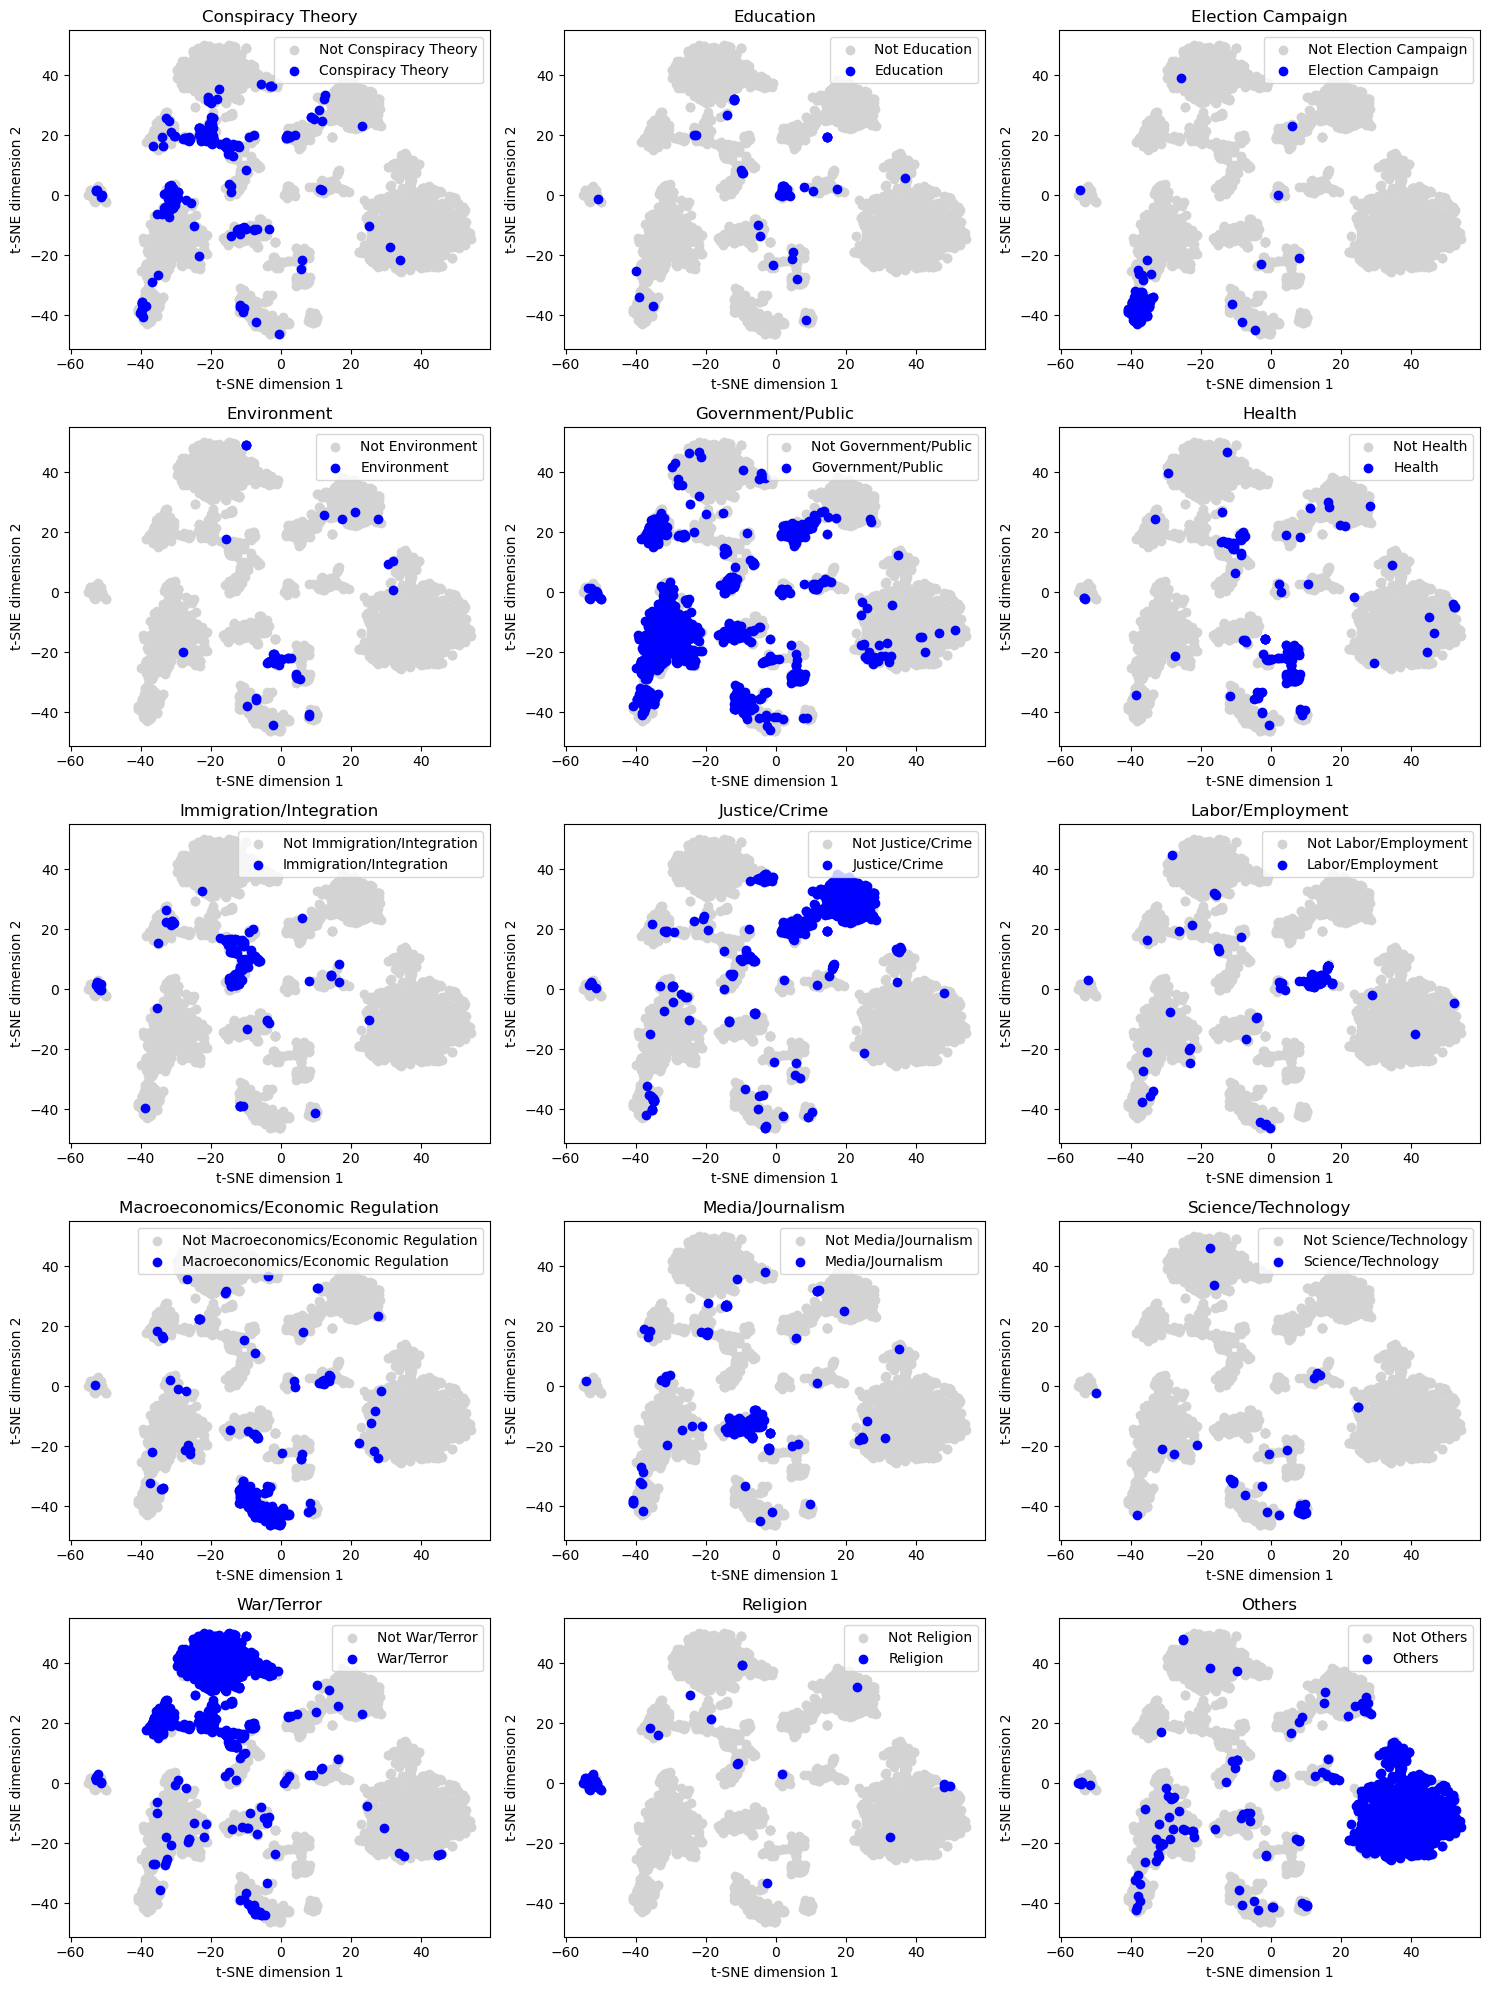

In [31]:
import matplotlib.pyplot as plt

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Election Campaign", "Environment", 
              "Government/Public", "Health", "Immigration/Integration", 
              "Justice/Crime", "Labor/Employment", 
              "Macroeconomics/Economic Regulation", "Media/Journalism", "Science/Technology", "War/Terror", "Religion", "Others"]

fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    label_rows = df_all[df_all['annotations'].apply(lambda x: class_name in x)]
        
    non_label_rows = df_all[df_all['annotations'].apply(lambda x: class_name not in x)]
    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')

    ax.scatter(label_rows['x'], label_rows['y'], color='blue', label=class_name)
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


Axes(0.125,0.53;0.352273x0.35)
Axes(0.547727,0.53;0.352273x0.35)


/tmp/ipykernel_17762/2516322214.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  match = self.df[self.df[column].str.contains(pattern)]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:19                                                                                   │
│                                                                                                  │
│   16 ax[1][0].set_xlabel('X')                                                                    │
│   17 ax[1][0].set_ylabel('Y')                                                                    │
│   18 ax[1][0].set_title('Lyrics in the vicinity of "Oak Island - Acoustic" by artist "Our Las    │
│ ❱ 19 tsne_helpers.plot_region_around("text", "Oak Island - Acoustic", fig, ax[1][0], clip_lab    │
│   20                                                                                             │
│   21 ax[1][1].set_xlabel('X')                                                                    │
│   22 ax[1][1].set_ylabel('Y')                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: TsneHelpers.plot_region_around() missing 1 required positional argument: 'ax'

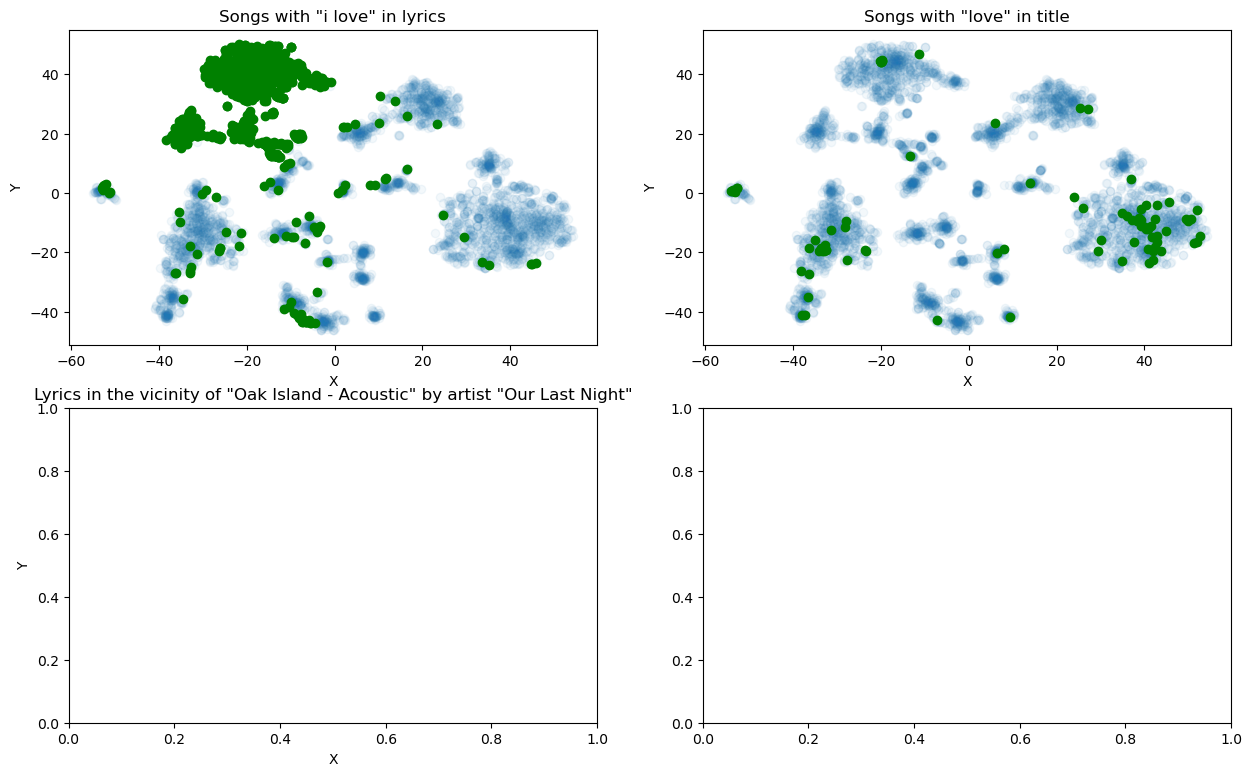

In [27]:
tsne_helpers = TsneHelpers(df_all, embs)

fig, ax = plt.subplots(2, 2, figsize=(15, 9))

ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('Y')
ax[0][0].set_title('Songs with "i love" in lyrics')
tsne_helpers.plot_by_pattern('annotations', 'War/Terror',  fig, ax[0][0],  bg_alpha=.05, text=False)


ax[0][1].set_xlabel('X')
ax[0][1].set_ylabel('Y')
ax[0][1].set_title('Songs with "love" in title')
tsne_helpers.plot_by_pattern('text', '([Ll]ove)', fig, ax[0][1], bg_alpha=.05, text=False)

ax[1][0].set_xlabel('X')
ax[1][0].set_ylabel('Y')
ax[1][0].set_title('Lyrics in the vicinity of "Oak Island - Acoustic" by artist "Our Last Night"')
tsne_helpers.plot_region_around("text", "Oak Island - Acoustic", fig, ax[1][0], clip_label="0:100", margin=2)

ax[1][1].set_xlabel('X')
ax[1][1].set_ylabel('Y')
ax[1][1].set_title('Genres in the vicinity of "Oak Island - Acoustic" by artist "Our Last Night"')
tsne_helpers.plot_region_around("text", "Oak Island - Acoustic", fig, ax[1][1], "0:100", 2)

Text(0.5, 1.0, 'TSNE of embeddings of 5000 songs (perplexity = 30, n_iter = 10000)')

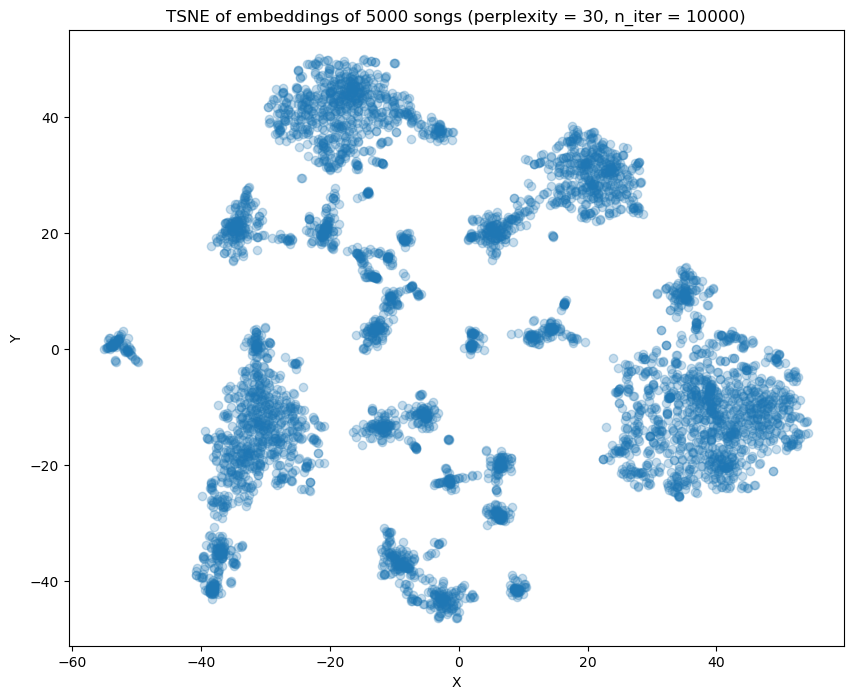

In [23]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df_all['x'], df_all['y'], alpha=.25)
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.set_title('TSNE of embeddings of 5000 songs (perplexity = 30, n_iter = 10000)')

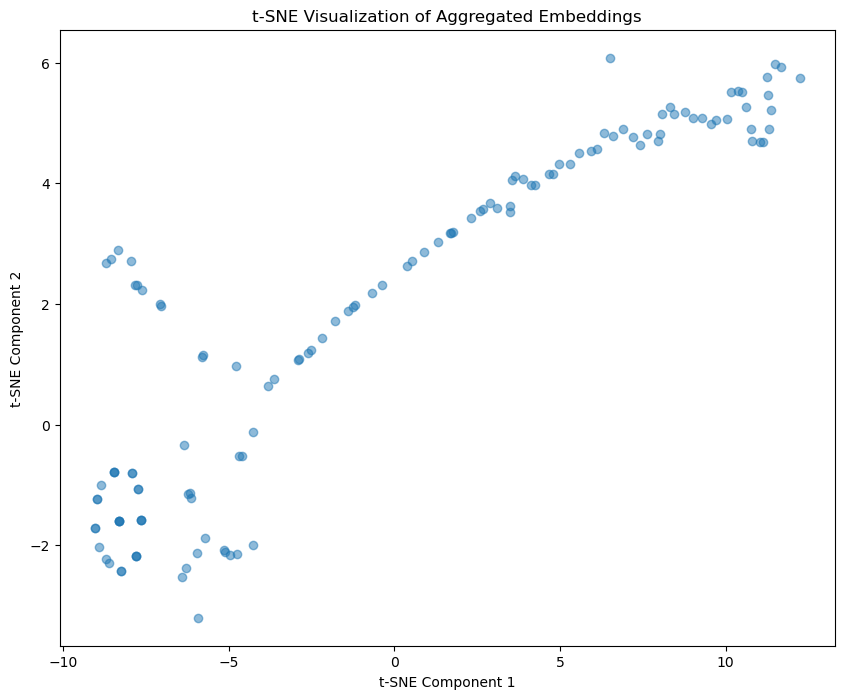

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

aggregated_embeddings = df_all.embeddings.mean(axis=0)

# Step 2: t-SNE Transformation
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(aggregated_embeddings)

# Step 3: Visualization
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Aggregated Embeddings')
plt.show()

In [9]:
df_all_vicuna = pd.read_csv("../data/embedded/labeled_data_plus_vicuna.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all_vicuna["embeddings"] = df_all_vicuna["embeddings"].apply(deserialize_embedding)

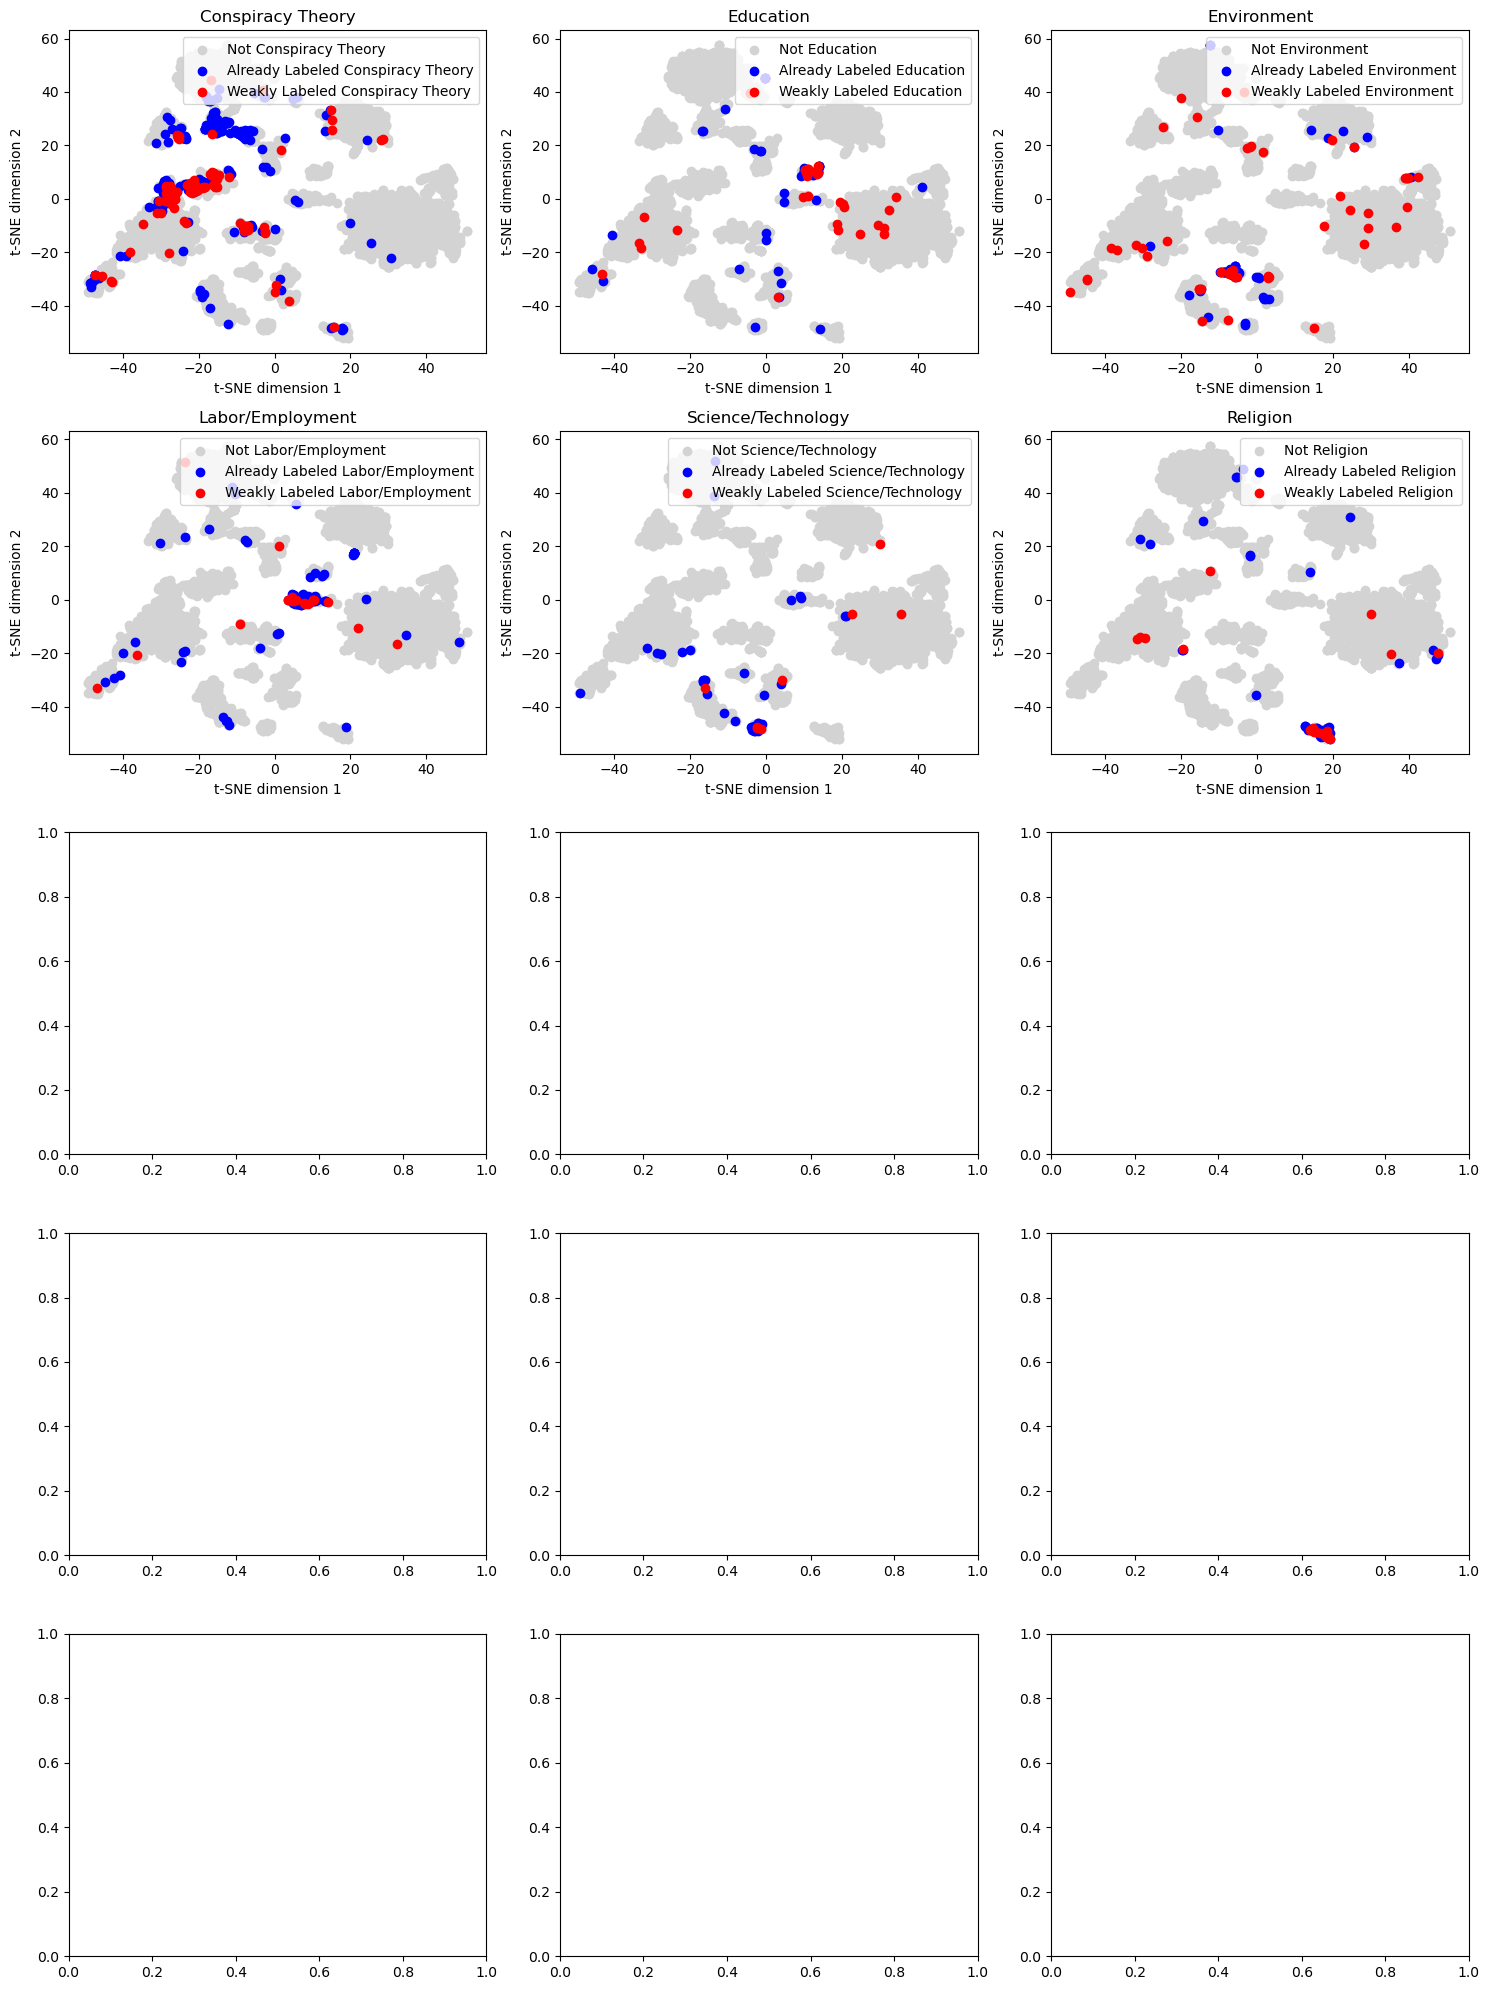

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all_vicuna.embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
embs = tsne.fit_transform(averaged_embeddings)
df_all_vicuna['x'] = embs[:,0]
df_all_vicuna['y'] = embs[:,1]

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Environment", "Labor/Employment", "Science/Technology", "Religion"]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    weakly_labeled_label_rows = df_all_vicuna[(df_all_vicuna['annotations'].apply(lambda x: class_name in x)) & (df_all_vicuna['weakly-labeled'] == True)]

    non_weakly_labeled_labeled_rows = df_all_vicuna[(df_all_vicuna['annotations'].apply(lambda x: class_name in x)) & (df_all_vicuna["weakly-labeled"] != True)]
    non_label_rows = df_all_vicuna[df_all_vicuna['annotations'].apply(lambda x: class_name not in x)]


    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')
    ax.scatter(non_weakly_labeled_labeled_rows['x'], non_weakly_labeled_labeled_rows['y'], color='blue', label=f'Already Labeled {class_name}')
    ax.scatter(weakly_labeled_label_rows['x'], weakly_labeled_label_rows['y'], color='red', label=f'Weakly Labeled {class_name}')
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


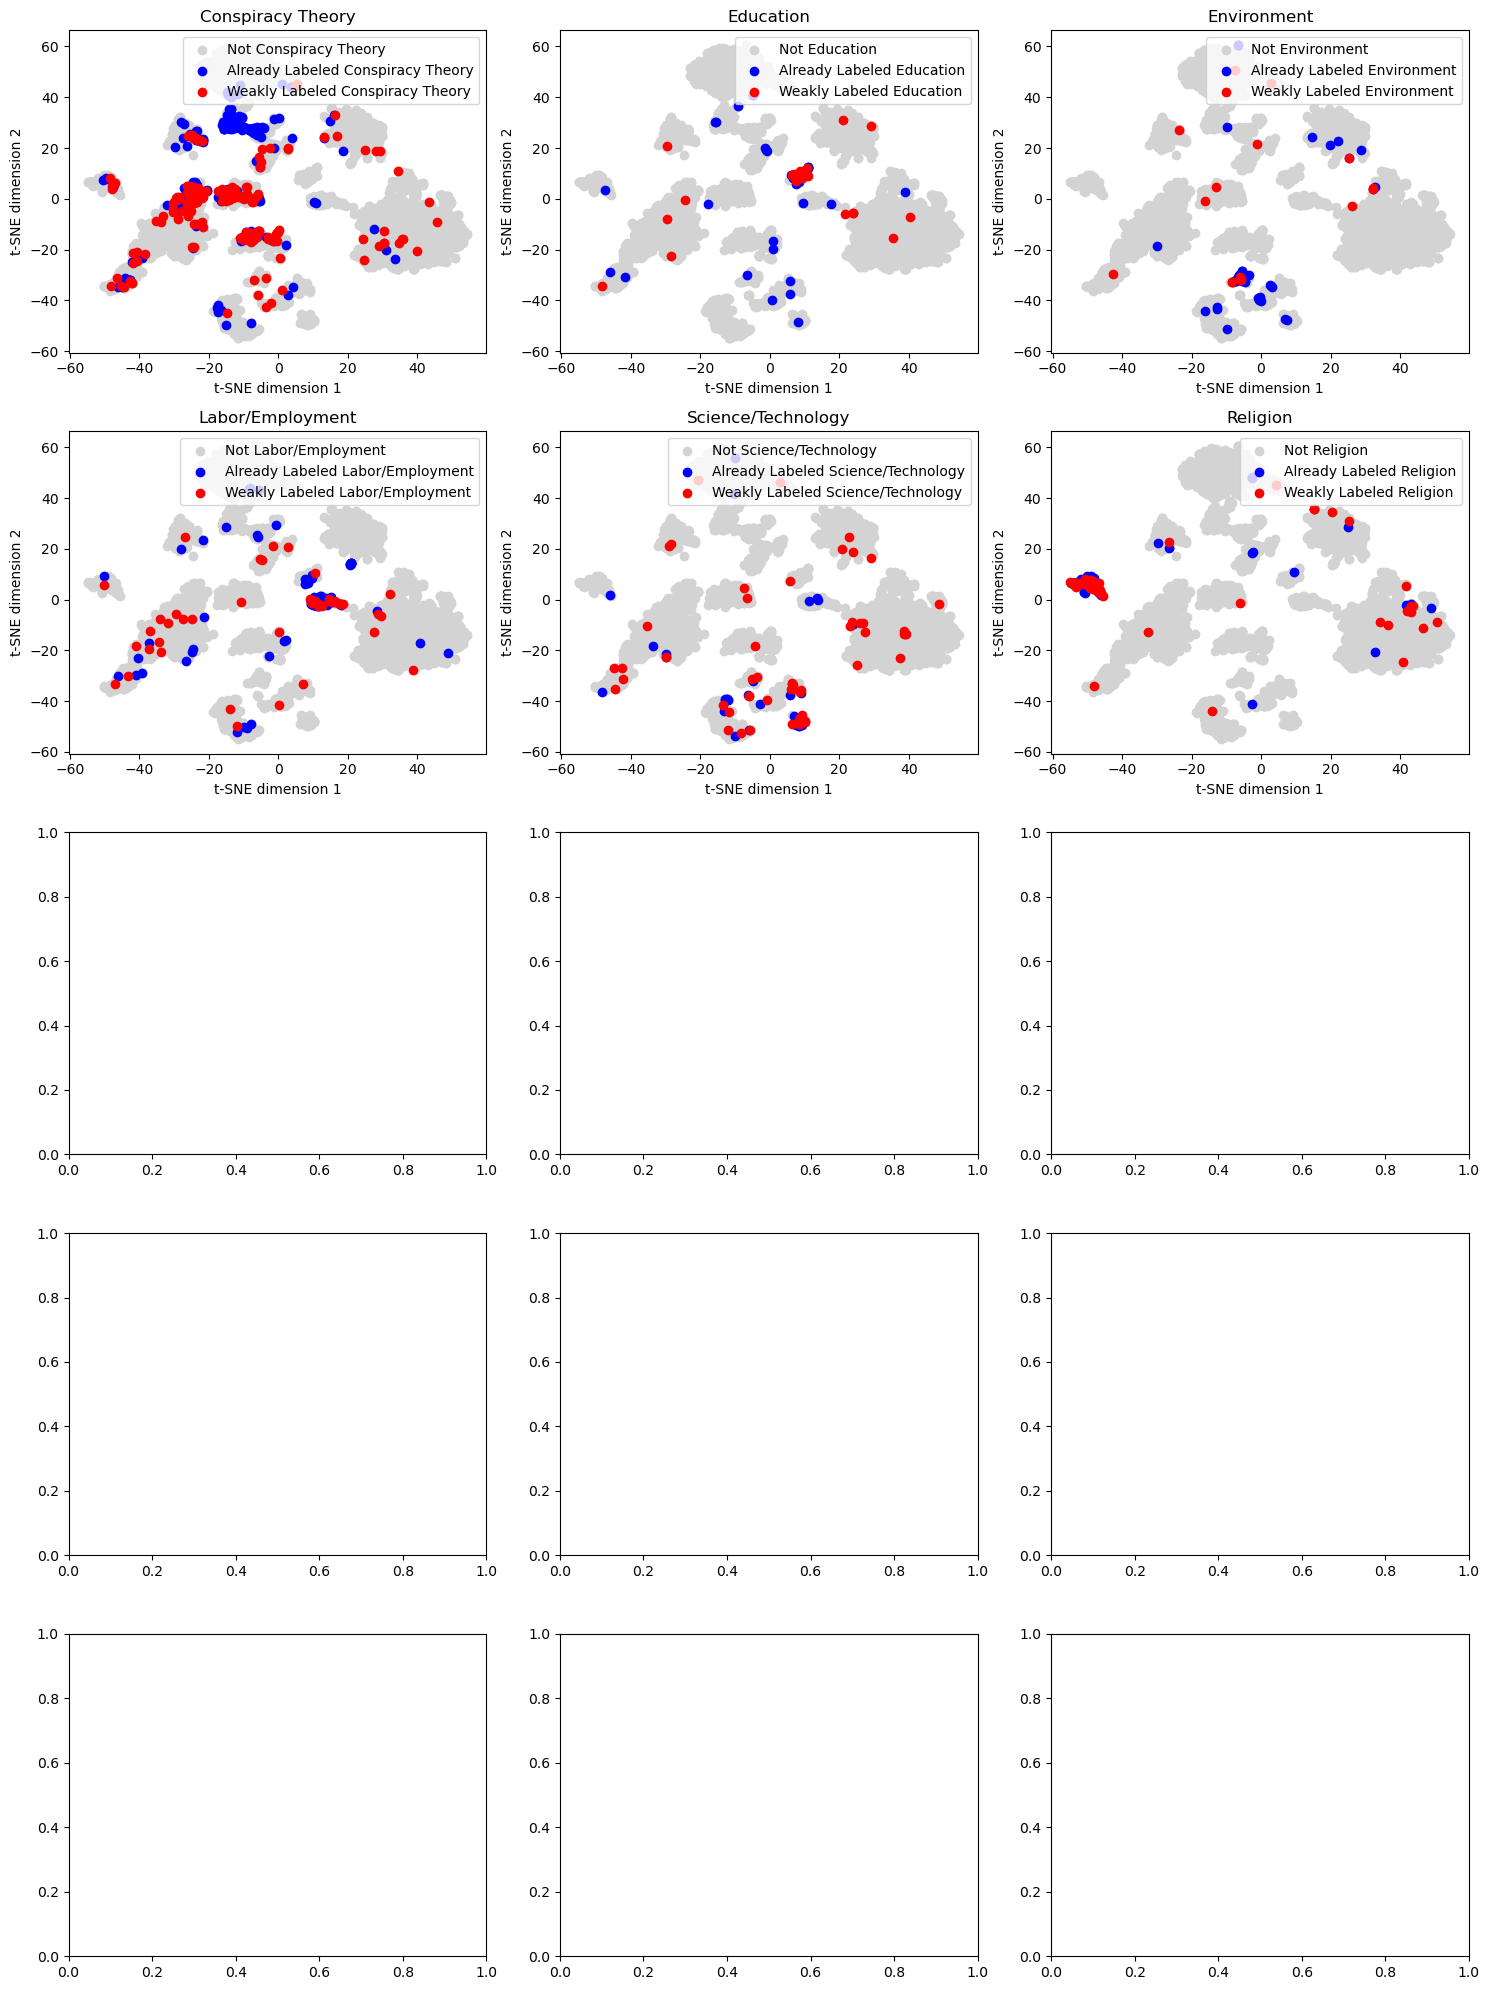

In [11]:
import pandas as pd
df_all_davinci = pd.read_csv("../data/embedded/labeled_data_plus_davinci.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all_davinci["embeddings"] = df_all_davinci["embeddings"].apply(deserialize_embedding)

embeddings = df_all_davinci["embeddings"].apply(deserialize_embedding)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all_davinci.embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
embs = tsne.fit_transform(averaged_embeddings)
df_all_davinci['x'] = embs[:,0]
df_all_davinci['y'] = embs[:,1]

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Environment", "Labor/Employment", "Science/Technology", "Religion"]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    weakly_labeled_label_rows = df_all_davinci[(df_all_davinci['annotations'].apply(lambda x: class_name in x)) & (df_all_davinci['weakly-labeled'] == True)]

    non_weakly_labeled_labeled_rows = df_all_davinci[(df_all_davinci['annotations'].apply(lambda x: class_name in x)) & (df_all_davinci["weakly-labeled"] != True)]
    non_label_rows = df_all_davinci[df_all_davinci['annotations'].apply(lambda x: class_name not in x)]


    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')
    ax.scatter(non_weakly_labeled_labeled_rows['x'], non_weakly_labeled_labeled_rows['y'], color='blue', label=f'Already Labeled {class_name}')
    ax.scatter(weakly_labeled_label_rows['x'], weakly_labeled_label_rows['y'], color='red', label=f'Weakly Labeled {class_name}')
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

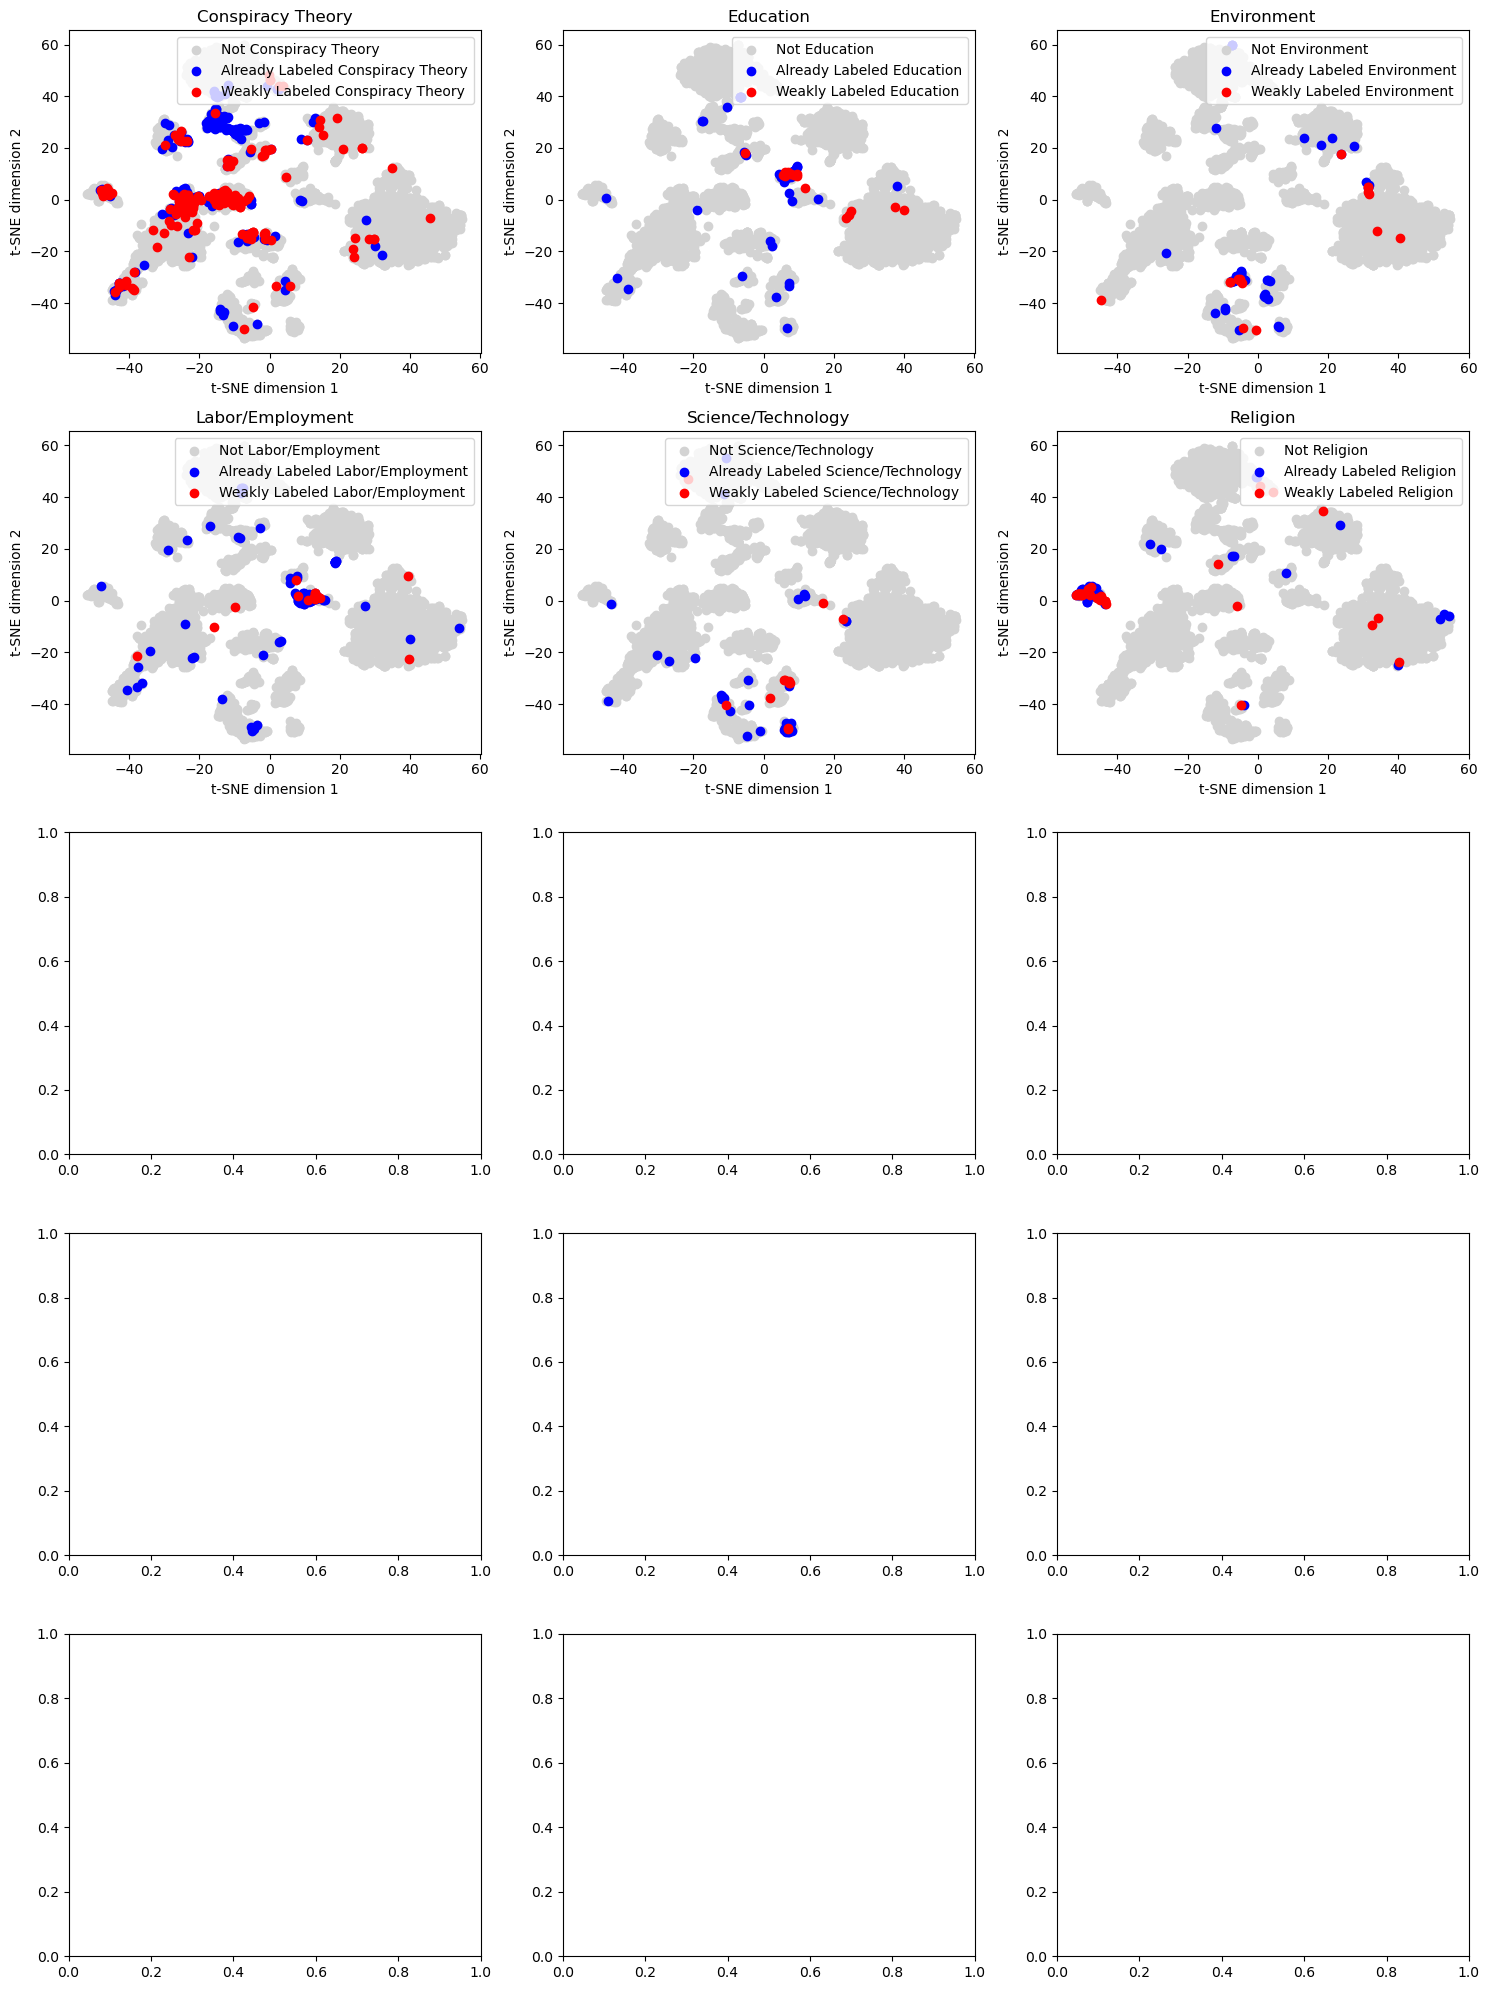

In [12]:
import pandas as pd
df_all_oa_v01 = pd.read_csv("../data/embedded/labeled_data_plus_oa_v01.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all_oa_v01["embeddings"] = df_all_oa_v01["embeddings"].apply(deserialize_embedding)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all_oa_v01.embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
embs = tsne.fit_transform(averaged_embeddings)
df_all_oa_v01['x'] = embs[:,0]
df_all_oa_v01['y'] = embs[:,1]

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Environment", "Labor/Employment", "Science/Technology", "Religion"]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    weakly_labeled_label_rows = df_all_oa_v01[(df_all_oa_v01['annotations'].apply(lambda x: class_name in x)) & (df_all_oa_v01['weakly-labeled'] == True)]

    non_weakly_labeled_labeled_rows = df_all_oa_v01[(df_all_oa_v01['annotations'].apply(lambda x: class_name in x)) & (df_all_oa_v01["weakly-labeled"] != True)]
    non_label_rows = df_all_oa_v01[df_all_oa_v01['annotations'].apply(lambda x: class_name not in x)]


    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')
    ax.scatter(non_weakly_labeled_labeled_rows['x'], non_weakly_labeled_labeled_rows['y'], color='blue', label=f'Already Labeled {class_name}')
    ax.scatter(weakly_labeled_label_rows['x'], weakly_labeled_label_rows['y'], color='red', label=f'Weakly Labeled {class_name}')
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [7]:
df_all_oa_v02

NameError: name 'df_all_oa_v02' is not defined

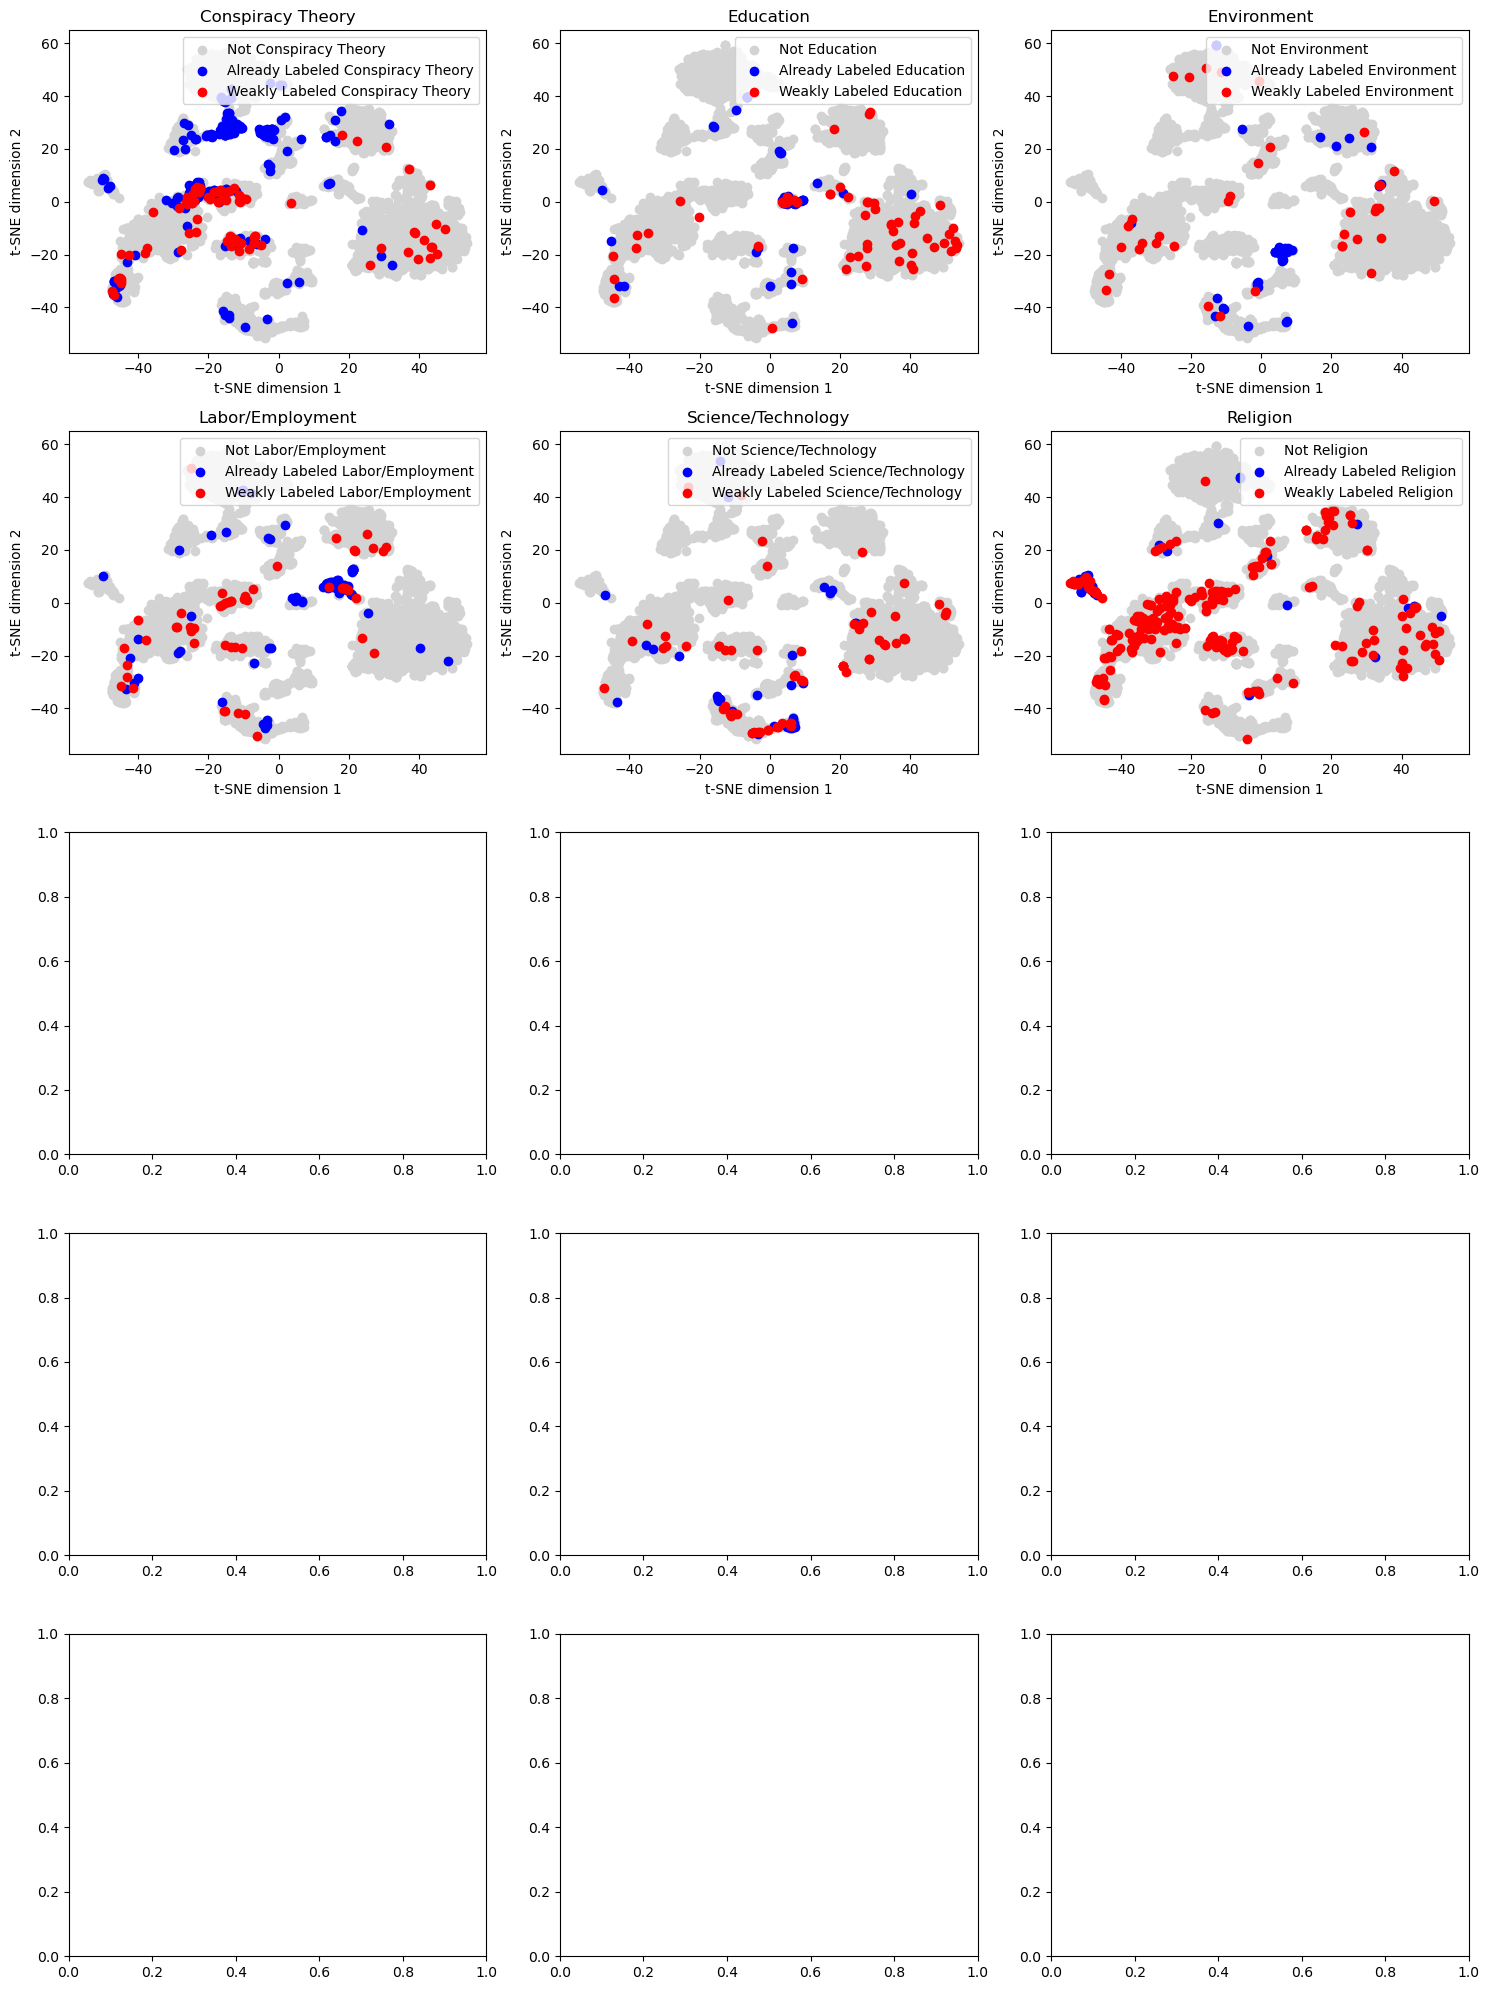

In [13]:
import pandas as pd
df_all_oa_v02 = pd.read_csv("../data/embedded/labeled_data_plus_oa_v02.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all_oa_v02["embeddings"] = df_all_oa_v02["embeddings"].apply(deserialize_embedding)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all_oa_v02.embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
embs = tsne.fit_transform(averaged_embeddings)
df_all_oa_v02['x'] = embs[:,0]
df_all_oa_v02['y'] = embs[:,1]

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Environment", "Labor/Employment", "Science/Technology", "Religion"]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    weakly_labeled_label_rows = df_all_oa_v02[(df_all_oa_v02['annotations'].apply(lambda x: class_name in x)) & (df_all_oa_v02['weakly-labeled'] == True)]

    non_weakly_labeled_labeled_rows = df_all_oa_v02[(df_all_oa_v02['annotations'].apply(lambda x: class_name in x)) & (df_all_oa_v02["weakly-labeled"] != True)]
    non_label_rows = df_all_oa_v02[df_all_oa_v02['annotations'].apply(lambda x: class_name not in x)]


    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')
    ax.scatter(non_weakly_labeled_labeled_rows['x'], non_weakly_labeled_labeled_rows['y'], color='blue', label=f'Already Labeled {class_name}')
    ax.scatter(weakly_labeled_label_rows['x'], weakly_labeled_label_rows['y'], color='red', label=f'Weakly Labeled {class_name}')
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

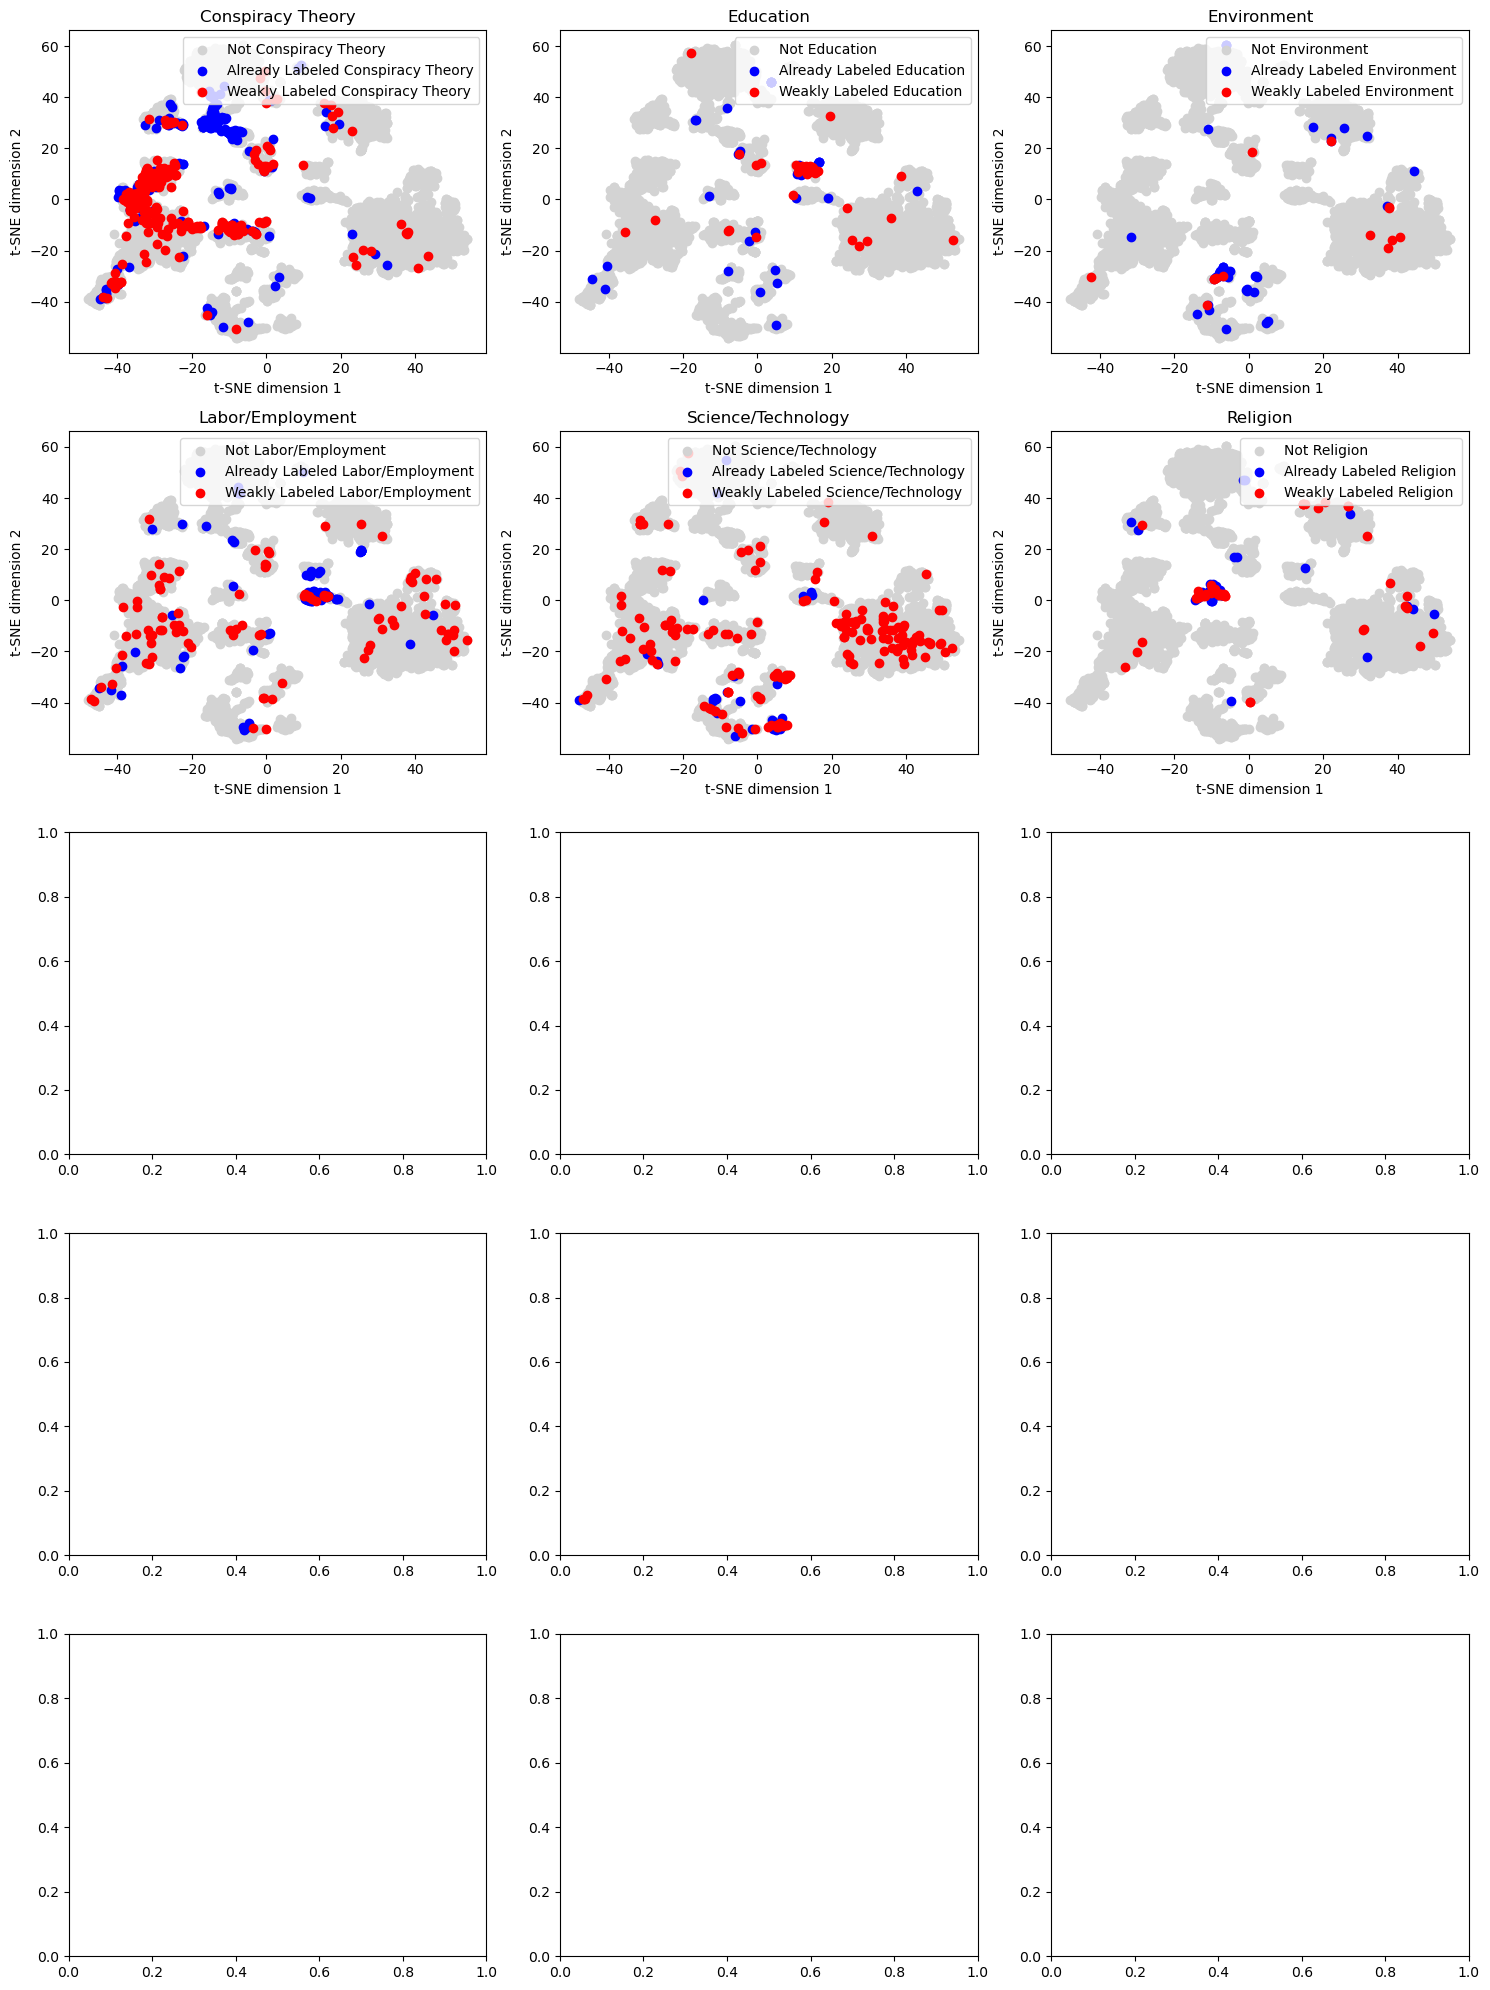

In [14]:
import pandas as pd
df_all_oa_v03 = pd.read_csv("../data/embedded/labeled_data_plus_oa_v03.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all_oa_v03["embeddings"] = df_all_oa_v03["embeddings"].apply(deserialize_embedding)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all_oa_v03.embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
embs = tsne.fit_transform(averaged_embeddings)
df_all_oa_v03['x'] = embs[:,0]
df_all_oa_v03['y'] = embs[:,1]

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Environment", "Labor/Employment", "Science/Technology", "Religion"]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    weakly_labeled_label_rows = df_all_oa_v03[(df_all_oa_v03['annotations'].apply(lambda x: class_name in x)) & (df_all_oa_v03['weakly-labeled'] == True)]

    non_weakly_labeled_labeled_rows = df_all_oa_v03[(df_all_oa_v03['annotations'].apply(lambda x: class_name in x)) & (df_all_oa_v03["weakly-labeled"] != True)]
    non_label_rows = df_all_oa_v03[df_all_oa_v03['annotations'].apply(lambda x: class_name not in x)]


    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')
    ax.scatter(non_weakly_labeled_labeled_rows['x'], non_weakly_labeled_labeled_rows['y'], color='blue', label=f'Already Labeled {class_name}')
    ax.scatter(weakly_labeled_label_rows['x'], weakly_labeled_label_rows['y'], color='red', label=f'Weakly Labeled {class_name}')
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
df_all_davinci = pd.read_csv("../data/embedded/labeled_data_plus_davinci.csv")

# Deserialize the embeddings
# Deserialize the embeddings
def deserialize_embedding(x):
    if isinstance(x, str):
        return pickle.loads(eval(x))
    return x

df_all_davinci["embeddings"] = df_all_davinci["embeddings"].apply(deserialize_embedding)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", perplexity=50.0)


embedding_list = np.array(df_all_davinci.embeddings.values.tolist())
averaged_embeddings = embedding_list.mean(axis=1)
embs = tsne.fit_transform(averaged_embeddings)
df_all_davinci['x'] = embs[:,0]
df_all_davinci['y'] = embs[:,1]

# List of classes
classes_to_check = ["Conspiracy Theory",  "Education", "Environment", "Labor/Employment", "Science/Technology", "Religion"]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5x3 grid of plots

for idx, class_name in enumerate(classes_to_check):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Points without the class        
    # 
    weakly_labeled_label_rows = df_all_davinci[(df_all_davinci['annotations'].apply(lambda x: class_name in x)) & (df_all_davinci['weakly-labeled'] == True)]

    non_weakly_labeled_labeled_rows = df_all_davinci[(df_all_davinci['annotations'].apply(lambda x: class_name in x)) & (df_all_davinci["weakly-labeled"] != True)]
    non_label_rows = df_all_davinci[df_all_davinci['annotations'].apply(lambda x: class_name not in x)]


    ax.scatter(non_label_rows['x'], non_label_rows['y'], color='lightgray', label=f'Not {class_name}')
    ax.scatter(weakly_labeled_label_rows['x'], weakly_labeled_label_rows['y'], color='red', label=f'Already labeled {class_name}')
    ax.scatter(non_weakly_labeled_labeled_rows['x'], non_weakly_labeled_labeled_rows['y'], color='blue', label=f'Weak labeled {class_name}')
    
    ax.set_title(f'{class_name}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# BASE

In [37]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.7083333333333334, 'recall': 0.3617021276595745, 'f1-score': 0.4788732394366197, 'support': 47}, 'Education': {'precision': 0.8888888888888888, 'recall': 0.6666666666666666, 'f1-score': 0.761904761904762, 'support': 12}, 'Election Campaign': {'precision': 0.7857142857142857, 'recall': 0.8461538461538461, 'f1-score': 0.8148148148148148, 'support': 26}, 'Environment': {'precision': 1.0, 'recall': 0.5714285714285714, 'f1-score': 0.7272727272727273, 'support': 14}, 'Government/Public': {'precision': 0.7517241379310344, 'recall': 0.8650793650793651, 'f1-score': 0.8044280442804428, 'support': 252}, 'Health': {'precision': 0.8604651162790697, 'recall': 0.8222222222222222, 'f1-score': 0.8409090909090908, 'support': 45}, 'Immigration/Integration': {'precision': 0.8387096774193549, 'recall': 0.65, 'f1-score': 0.7323943661971831, 'support': 40}, 'Justice/Crime': {'precision': 0.7452830188679245, 'recall': 0.7383177570093458, 'f1-score': 0.7417840375586855, 's

# ALL

In [45]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("vicuna_with_rules_classification_only_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.71875, 'recall': 0.48936170212765956, 'f1-score': 0.5822784810126582, 'support': 47}, 'Education': {'precision': 0.8333333333333334, 'recall': 0.4166666666666667, 'f1-score': 0.5555555555555556, 'support': 12}, 'Election Campaign': {'precision': 0.8095238095238095, 'recall': 0.6538461538461539, 'f1-score': 0.7234042553191489, 'support': 26}, 'Environment': {'precision': 0.8461538461538461, 'recall': 0.7857142857142857, 'f1-score': 0.8148148148148148, 'support': 14}, 'Government/Public': {'precision': 0.820627802690583, 'recall': 0.7261904761904762, 'f1-score': 0.7705263157894737, 'support': 252}, 'Health': {'precision': 0.9047619047619048, 'recall': 0.8444444444444444, 'f1-score': 0.8735632183908046, 'support': 45}, 'Immigration/Integration': {'precision': 0.90625, 'recall': 0.725, 'f1-score': 0.8055555555555555, 'support': 40}, 'Justice/Crime': {'precision': 0.7906976744186046, 'recall': 0.6355140186915887, 'f1-score': 0.7046632124352331, 'suppor

In [47]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_with_rules_classification_only_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.6956521739130435, 'recall': 0.3404255319148936, 'f1-score': 0.4571428571428571, 'support': 47}, 'Education': {'precision': 0.8888888888888888, 'recall': 0.6666666666666666, 'f1-score': 0.761904761904762, 'support': 12}, 'Election Campaign': {'precision': 0.7586206896551724, 'recall': 0.8461538461538461, 'f1-score': 0.8, 'support': 26}, 'Environment': {'precision': 0.9, 'recall': 0.6428571428571429, 'f1-score': 0.75, 'support': 14}, 'Government/Public': {'precision': 0.7551724137931034, 'recall': 0.8690476190476191, 'f1-score': 0.8081180811808119, 'support': 252}, 'Health': {'precision': 0.9, 'recall': 0.8, 'f1-score': 0.8470588235294118, 'support': 45}, 'Immigration/Integration': {'precision': 0.7837837837837838, 'recall': 0.725, 'f1-score': 0.7532467532467533, 'support': 40}, 'Justice/Crime': {'precision': 0.7547169811320755, 'recall': 0.7476635514018691, 'f1-score': 0.7511737089201879, 'support': 107}, 'Labor/Employment': {'precision': 0.7, 'rec

In [46]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_with_3_random_examples_classification_only_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.4642857142857143, 'recall': 0.5531914893617021, 'f1-score': 0.5048543689320388, 'support': 47}, 'Education': {'precision': 0.4, 'recall': 0.5, 'f1-score': 0.4444444444444445, 'support': 12}, 'Election Campaign': {'precision': 0.9411764705882353, 'recall': 0.6153846153846154, 'f1-score': 0.744186046511628, 'support': 26}, 'Environment': {'precision': 0.6363636363636364, 'recall': 0.5, 'f1-score': 0.56, 'support': 14}, 'Government/Public': {'precision': 0.8203592814371258, 'recall': 0.5436507936507936, 'f1-score': 0.6539379474940333, 'support': 252}, 'Health': {'precision': 0.9047619047619048, 'recall': 0.8444444444444444, 'f1-score': 0.8735632183908046, 'support': 45}, 'Immigration/Integration': {'precision': 0.9473684210526315, 'recall': 0.45, 'f1-score': 0.6101694915254237, 'support': 40}, 'Justice/Crime': {'precision': 0.8082191780821918, 'recall': 0.5514018691588785, 'f1-score': 0.6555555555555554, 'support': 107}, 'Labor/Employment': {'precisi

In [44]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_classification_only_v03_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.375, 'recall': 0.5106382978723404, 'f1-score': 0.43243243243243246, 'support': 47}, 'Education': {'precision': 0.5714285714285714, 'recall': 0.3333333333333333, 'f1-score': 0.4210526315789474, 'support': 12}, 'Election Campaign': {'precision': 0.9285714285714286, 'recall': 0.5, 'f1-score': 0.65, 'support': 26}, 'Environment': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 14}, 'Government/Public': {'precision': 0.8115942028985508, 'recall': 0.6666666666666666, 'f1-score': 0.7320261437908496, 'support': 252}, 'Health': {'precision': 0.9142857142857143, 'recall': 0.7111111111111111, 'f1-score': 0.8, 'support': 45}, 'Immigration/Integration': {'precision': 0.8928571428571429, 'recall': 0.625, 'f1-score': 0.7352941176470589, 'support': 40}, 'Justice/Crime': {'precision': 0.7708333333333334, 'recall': 0.6915887850467289, 'f1-score': 0.7290640394088671, 'support': 107}, 'Labor/Employment': {'pr

In [43]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("davinci_elaboration_first_v04_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.7647058823529411, 'recall': 0.2765957446808511, 'f1-score': 0.40624999999999994, 'support': 47}, 'Education': {'precision': 0.7777777777777778, 'recall': 0.5833333333333334, 'f1-score': 0.6666666666666666, 'support': 12}, 'Election Campaign': {'precision': 0.782608695652174, 'recall': 0.6923076923076923, 'f1-score': 0.7346938775510203, 'support': 26}, 'Environment': {'precision': 0.7272727272727273, 'recall': 0.5714285714285714, 'f1-score': 0.64, 'support': 14}, 'Government/Public': {'precision': 0.8266666666666667, 'recall': 0.7380952380952381, 'f1-score': 0.779874213836478, 'support': 252}, 'Health': {'precision': 0.9210526315789473, 'recall': 0.7777777777777778, 'f1-score': 0.8433734939759038, 'support': 45}, 'Immigration/Integration': {'precision': 0.7741935483870968, 'recall': 0.6, 'f1-score': 0.676056338028169, 'support': 40}, 'Justice/Crime': {'precision': 0.8295454545454546, 'recall': 0.6822429906542056, 'f1-score': 0.7487179487179487, 'su

# Distinct

In [42]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("vicuna_with_rules_classification_only_distinct_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.6304347826086957, 'recall': 0.6170212765957447, 'f1-score': 0.6236559139784946, 'support': 47}, 'Education': {'precision': 0.625, 'recall': 0.8333333333333334, 'f1-score': 0.7142857142857143, 'support': 12}, 'Election Campaign': {'precision': 0.75, 'recall': 0.6923076923076923, 'f1-score': 0.7199999999999999, 'support': 26}, 'Environment': {'precision': 0.9090909090909091, 'recall': 0.7142857142857143, 'f1-score': 0.8, 'support': 14}, 'Government/Public': {'precision': 0.7580071174377224, 'recall': 0.8452380952380952, 'f1-score': 0.799249530956848, 'support': 252}, 'Health': {'precision': 0.8, 'recall': 0.8888888888888888, 'f1-score': 0.8421052631578948, 'support': 45}, 'Immigration/Integration': {'precision': 0.6956521739130435, 'recall': 0.8, 'f1-score': 0.7441860465116279, 'support': 40}, 'Justice/Crime': {'precision': 0.8202247191011236, 'recall': 0.6822429906542056, 'f1-score': 0.7448979591836734, 'support': 107}, 'Labor/Employment': {'precis

In [41]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_with_rules_classification_only_distinct_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.5714285714285714, 'recall': 0.5106382978723404, 'f1-score': 0.5393258426966292, 'support': 47}, 'Education': {'precision': 0.8333333333333334, 'recall': 0.4166666666666667, 'f1-score': 0.5555555555555556, 'support': 12}, 'Election Campaign': {'precision': 0.7692307692307693, 'recall': 0.7692307692307693, 'f1-score': 0.7692307692307693, 'support': 26}, 'Environment': {'precision': 0.8, 'recall': 0.8571428571428571, 'f1-score': 0.8275862068965518, 'support': 14}, 'Government/Public': {'precision': 0.7954545454545454, 'recall': 0.8333333333333334, 'f1-score': 0.8139534883720929, 'support': 252}, 'Health': {'precision': 0.925, 'recall': 0.8222222222222222, 'f1-score': 0.8705882352941177, 'support': 45}, 'Immigration/Integration': {'precision': 0.7674418604651163, 'recall': 0.825, 'f1-score': 0.7951807228915662, 'support': 40}, 'Justice/Crime': {'precision': 0.8152173913043478, 'recall': 0.7009345794392523, 'f1-score': 0.7537688442211056, 'support': 10

In [40]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_with_3_random_examples_classification_only_distinct_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.7083333333333334, 'recall': 0.3617021276595745, 'f1-score': 0.4788732394366197, 'support': 47}, 'Education': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 12}, 'Election Campaign': {'precision': 0.8571428571428571, 'recall': 0.6923076923076923, 'f1-score': 0.7659574468085107, 'support': 26}, 'Environment': {'precision': 0.8, 'recall': 0.5714285714285714, 'f1-score': 0.6666666666666666, 'support': 14}, 'Government/Public': {'precision': 0.8225108225108225, 'recall': 0.753968253968254, 'f1-score': 0.7867494824016563, 'support': 252}, 'Health': {'precision': 0.8809523809523809, 'recall': 0.8222222222222222, 'f1-score': 0.8505747126436781, 'support': 45}, 'Immigration/Integration': {'precision': 0.9032258064516129, 'recall': 0.7, 'f1-score': 0.7887323943661972, 'support': 40}, 'Justice/Crime': {'precision': 0.7951807228915663, 'recall': 0.616822429906542, 'f1-score': 0.6947368421052631, 'support': 107}, 'L

In [39]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_classification_only_v03_distinct_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.8888888888888888, 'recall': 0.1702127659574468, 'f1-score': 0.2857142857142857, 'support': 47}, 'Education': {'precision': 0.8571428571428571, 'recall': 0.5, 'f1-score': 0.631578947368421, 'support': 12}, 'Election Campaign': {'precision': 0.9230769230769231, 'recall': 0.46153846153846156, 'f1-score': 0.6153846153846155, 'support': 26}, 'Environment': {'precision': 0.8333333333333334, 'recall': 0.7142857142857143, 'f1-score': 0.7692307692307692, 'support': 14}, 'Government/Public': {'precision': 0.8208333333333333, 'recall': 0.7817460317460317, 'f1-score': 0.8008130081300813, 'support': 252}, 'Health': {'precision': 0.9512195121951219, 'recall': 0.8666666666666667, 'f1-score': 0.9069767441860465, 'support': 45}, 'Immigration/Integration': {'precision': 0.8928571428571429, 'recall': 0.625, 'f1-score': 0.7352941176470589, 'support': 40}, 'Justice/Crime': {'precision': 0.8333333333333334, 'recall': 0.6074766355140186, 'f1-score': 0.7027027027027027, 

In [38]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("davinci_elaboration_first_v04_distinct_generic")

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.6129032258064516, 'recall': 0.40425531914893614, 'f1-score': 0.48717948717948717, 'support': 47}, 'Education': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 12}, 'Election Campaign': {'precision': 0.8260869565217391, 'recall': 0.7307692307692307, 'f1-score': 0.7755102040816326, 'support': 26}, 'Environment': {'precision': 0.7272727272727273, 'recall': 0.5714285714285714, 'f1-score': 0.64, 'support': 14}, 'Government/Public': {'precision': 0.7319587628865979, 'recall': 0.8452380952380952, 'f1-score': 0.7845303867403314, 'support': 252}, 'Health': {'precision': 0.9210526315789473, 'recall': 0.7777777777777778, 'f1-score': 0.8433734939759038, 'support': 45}, 'Immigration/Integration': {'precision': 0.8484848484848485, 'recall': 0.7, 'f1-score': 0.7671232876712328, 'support': 40}, 'Justice/Crime': {'precision': 0.8311688311688312, 'recall': 0.5981308411214953, 'f1-score': 0.6956521739130436, 'support': 107}, 'Labor/Employment': {'prec

# Co-Occurrence

In [15]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("vicuna_with_rules_classification_only_co_occurrence_generic")

../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
3436                                 ['Labor/Employment']
3437                                        ['Education']
3438                                ['Conspiracy Theory']
3439                                ['Conspiracy Theory']
3440                                        ['Education']
Name: annotations, Length: 3441, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regula

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
3436                                 ['Labor/Employment']
3437                                        ['Education']
3438                                ['Conspiracy Theory']
3439                                ['Conspiracy Theory']
3440                                        ['Education']
Name: annotations, Length: 3441, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regula

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
3436      ['Labor/Employment']
3437             ['Education']
3438     ['Conspiracy Theory']
3439     ['Conspiracy Theory']
3440             ['Education']
Name: annotations, Length: 3441, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
3436                                 ['Labor/Employment']
3437                                        ['Education']
3438                                ['Conspiracy Theory']
3439                                ['Conspiracy Theory']
3440                                        ['Education']
Name: annotations, Length: 3441, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regula

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
3436                                 ['Labor/Employment']
3437                                        ['Education']
3438                                ['Conspiracy Theory']
3439                                ['Conspiracy Theory']
3440                                        ['Education']
Name: annotations, Length: 3441, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regula

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.49122807017543857, 'recall': 0.5957446808510638, 'f1-score': 0.5384615384615384, 'support': 47}, 'Education': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 12}, 'Election Campaign': {'precision': 0.76, 'recall': 0.7307692307692307, 'f1-score': 0.7450980392156863, 'support': 26}, 'Environment': {'precision': 0.65, 'recall': 0.9285714285714286, 'f1-score': 0.7647058823529412, 'support': 14}, 'Government/Public': {'precision': 0.8015564202334631, 'recall': 0.8174603174603174, 'f1-score': 0.8094302554027505, 'support': 252}, 'Health': {'precision': 0.7962962962962963, 'recall': 0.9555555555555556, 'f1-score': 0.8686868686868687, 'support': 45}, 'Immigration/Integration': {'precision': 0.7674418604651163, 'recall': 0.825, 'f1-score': 0.7951807228915662, 'support': 40}, 'Justice/Crime': {'precision': 0.81, 'recall': 0.7570093457943925, 'f1-score': 0.782608695652174, 'support': 107}, 'Labor/Emp

In [14]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_with_rules_classification_only_co_occurrence_generic")

../models/weak_labeled/oa_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
3480                                 ['Labor/Employment']
3481                                         ['Religion']
3482                                        ['Education']
3483                                ['Conspiracy Theory']
3484                                ['Conspiracy Theory']
Name: annotations, Length: 3485, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
3480                                 ['Labor/Employment']
3481                                         ['Religion']
3482                                        ['Education']
3483                                ['Conspiracy Theory']
3484                                ['Conspiracy Theory']
Name: annotations, Length: 3485, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
3480      ['Labor/Employment']
3481              ['Religion']
3482             ['Education']
3483     ['Conspiracy Theory']
3484     ['Conspiracy Theory']
Name: annotations, Length: 3485, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
3480                                 ['Labor/Employment']
3481                                         ['Religion']
3482                                        ['Education']
3483                                ['Conspiracy Theory']
3484                                ['Conspiracy Theory']
Name: annotations, Length: 3485, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_rules_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
3480                                 ['Labor/Employment']
3481                                         ['Religion']
3482                                        ['Education']
3483                                ['Conspiracy Theory']
3484                                ['Conspiracy Theory']
Name: annotations, Length: 3485, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.5757575757575758, 'recall': 0.40425531914893614, 'f1-score': 0.47500000000000003, 'support': 47}, 'Education': {'precision': 1.0, 'recall': 0.5833333333333334, 'f1-score': 0.7368421052631579, 'support': 12}, 'Election Campaign': {'precision': 0.8421052631578947, 'recall': 0.6153846153846154, 'f1-score': 0.7111111111111111, 'support': 26}, 'Environment': {'precision': 0.8461538461538461, 'recall': 0.7857142857142857, 'f1-score': 0.8148148148148148, 'support': 14}, 'Government/Public': {'precision': 0.7854406130268199, 'recall': 0.8134920634920635, 'f1-score': 0.7992202729044834, 'support': 252}, 'Health': {'precision': 0.9285714285714286, 'recall': 0.8666666666666667, 'f1-score': 0.896551724137931, 'support': 45}, 'Immigration/Integration': {'precision': 0.717391304347826, 'recall': 0.825, 'f1-score': 0.7674418604651162, 'support': 40}, 'Justice/Crime': {'precision': 0.8105263157894737, 'recall': 0.719626168224299, 'f1-score': 0.7623762376237623, '

In [13]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_with_3_random_examples_classification_only_co_occurrence_generic")

../models/weak_labeled/oa_with_3_random_examples_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
3759                                 ['Labor/Employment']
3760                                 ['Labor/Employment']
3761                                        ['Education']
3762                                         ['Religion']
3763                                         ['Religion']
Name: annotations, Length: 3764, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economi

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_3_random_examples_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
3759                                 ['Labor/Employment']
3760                                 ['Labor/Employment']
3761                                        ['Education']
3762                                         ['Religion']
3763                                         ['Religion']
Name: annotations, Length: 3764, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economi

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_3_random_examples_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
3759      ['Labor/Employment']
3760      ['Labor/Employment']
3761             ['Education']
3762              ['Religion']
3763              ['Religion']
Name: annotations, Length: 3764, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_3_random_examples_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
3759                                 ['Labor/Employment']
3760                                 ['Labor/Employment']
3761                                        ['Education']
3762                                         ['Religion']
3763                                         ['Religion']
Name: annotations, Length: 3764, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economi

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_with_3_random_examples_classification_only_co_occurrence_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
3759                                 ['Labor/Employment']
3760                                 ['Labor/Employment']
3761                                        ['Education']
3762                                         ['Religion']
3763                                         ['Religion']
Name: annotations, Length: 3764, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economi

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.5806451612903226, 'recall': 0.3829787234042553, 'f1-score': 0.46153846153846156, 'support': 47}, 'Education': {'precision': 0.9, 'recall': 0.75, 'f1-score': 0.8181818181818182, 'support': 12}, 'Election Campaign': {'precision': 0.9411764705882353, 'recall': 0.6153846153846154, 'f1-score': 0.744186046511628, 'support': 26}, 'Environment': {'precision': 0.7857142857142857, 'recall': 0.7857142857142857, 'f1-score': 0.7857142857142857, 'support': 14}, 'Government/Public': {'precision': 0.8111587982832618, 'recall': 0.75, 'f1-score': 0.7793814432989691, 'support': 252}, 'Health': {'precision': 0.95, 'recall': 0.8444444444444444, 'f1-score': 0.8941176470588236, 'support': 45}, 'Immigration/Integration': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1-score': 0.7999999999999999, 'support': 40}, 'Justice/Crime': {'precision': 0.8205128205128205, 'recall': 0.5981308411214953, 'f1-score': 0.6918918918918919, 'support': 107}, 'Labor/Employment': {'prec

In [12]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("oa_classification_only_v03_co_occurrence_generic")

../models/weak_labeled/oa_classification_only_v03_co_occurrence_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
3822                                 ['Labor/Employment']
3823                                         ['Religion']
3824                                        ['Education']
3825                               ['Science/Technology']
3826                               ['Science/Technology']
Name: annotations, Length: 3827, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Med

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_classification_only_v03_co_occurrence_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
3822                                 ['Labor/Employment']
3823                                         ['Religion']
3824                                        ['Education']
3825                               ['Science/Technology']
3826                               ['Science/Technology']
Name: annotations, Length: 3827, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Med

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_classification_only_v03_co_occurrence_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
3822      ['Labor/Employment']
3823              ['Religion']
3824             ['Education']
3825    ['Science/Technology']
3826    ['Science/Technology']
Name: annotations, Length: 3827, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_classification_only_v03_co_occurrence_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
3822                                 ['Labor/Employment']
3823                                         ['Religion']
3824                                        ['Education']
3825                               ['Science/Technology']
3826                               ['Science/Technology']
Name: annotations, Length: 3827, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Med

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/oa_classification_only_v03_co_occurrence_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
3822                                 ['Labor/Employment']
3823                                         ['Religion']
3824                                        ['Education']
3825                               ['Science/Technology']
3826                               ['Science/Technology']
Name: annotations, Length: 3827, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Med

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.7083333333333334, 'recall': 0.3617021276595745, 'f1-score': 0.4788732394366197, 'support': 47}, 'Education': {'precision': 0.7777777777777778, 'recall': 0.5833333333333334, 'f1-score': 0.6666666666666666, 'support': 12}, 'Election Campaign': {'precision': 0.8421052631578947, 'recall': 0.6153846153846154, 'f1-score': 0.7111111111111111, 'support': 26}, 'Environment': {'precision': 0.8571428571428571, 'recall': 0.42857142857142855, 'f1-score': 0.5714285714285714, 'support': 14}, 'Government/Public': {'precision': 0.819672131147541, 'recall': 0.7936507936507936, 'f1-score': 0.8064516129032259, 'support': 252}, 'Health': {'precision': 0.9444444444444444, 'recall': 0.7555555555555555, 'f1-score': 0.8395061728395062, 'support': 45}, 'Immigration/Integration': {'precision': 0.896551724137931, 'recall': 0.65, 'f1-score': 0.7536231884057972, 'support': 40}, 'Justice/Crime': {'precision': 0.8375, 'recall': 0.6261682242990654, 'f1-score': 0.7165775401069518,

In [11]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("davinci_elaboration_first_v04_co_occurrence_generic")

../models/weak_labeled/davinci_elaboration_first_v04_co_occurrence_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
3630                                         ['Religion']
3631                                        ['Education']
3632                                ['Conspiracy Theory']
3633                                ['Conspiracy Theory']
3634                               ['Science/Technology']
Name: annotations, Length: 3635, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', '

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/davinci_elaboration_first_v04_co_occurrence_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
3630                                         ['Religion']
3631                                        ['Education']
3632                                ['Conspiracy Theory']
3633                                ['Conspiracy Theory']
3634                               ['Science/Technology']
Name: annotations, Length: 3635, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', '

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/davinci_elaboration_first_v04_co_occurrence_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
3630              ['Religion']
3631             ['Education']
3632     ['Conspiracy Theory']
3633     ['Conspiracy Theory']
3634    ['Science/Technology']
Name: annotations, Length: 3635, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/davinci_elaboration_first_v04_co_occurrence_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
3630                                         ['Religion']
3631                                        ['Education']
3632                                ['Conspiracy Theory']
3633                                ['Conspiracy Theory']
3634                               ['Science/Technology']
Name: annotations, Length: 3635, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', '

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/davinci_elaboration_first_v04_co_occurrence_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
3630                                         ['Religion']
3631                                        ['Education']
3632                                ['Conspiracy Theory']
3633                                ['Conspiracy Theory']
3634                               ['Science/Technology']
Name: annotations, Length: 3635, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', '

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.6285714285714286, 'recall': 0.46808510638297873, 'f1-score': 0.5365853658536586, 'support': 47}, 'Education': {'precision': 0.75, 'recall': 0.5, 'f1-score': 0.6, 'support': 12}, 'Election Campaign': {'precision': 0.8571428571428571, 'recall': 0.6923076923076923, 'f1-score': 0.7659574468085107, 'support': 26}, 'Environment': {'precision': 0.8333333333333334, 'recall': 0.7142857142857143, 'f1-score': 0.7692307692307692, 'support': 14}, 'Government/Public': {'precision': 0.7597173144876325, 'recall': 0.8531746031746031, 'f1-score': 0.8037383177570093, 'support': 252}, 'Health': {'precision': 0.9, 'recall': 0.8, 'f1-score': 0.8470588235294118, 'support': 45}, 'Immigration/Integration': {'precision': 0.9310344827586207, 'recall': 0.675, 'f1-score': 0.7826086956521738, 'support': 40}, 'Justice/Crime': {'precision': 0.8045977011494253, 'recall': 0.6542056074766355, 'f1-score': 0.7216494845360825, 'support': 107}, 'Labor/Employment': {'precision': 0.73684

# LLM Data Augment

In [50]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("vicuna_augmented_v01_augmented", weak_labeled = False) # alpha = 0.1 n_aug = 4

/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_30576/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.5806451612903226, 'recall': 0.3829787234042553, 'f1-score': 0.46153846153846156, 'support': 47}, 'Education': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 12}, 'Election Campaign': {'precision': 0.6764705882352942, 'recall': 0.8846153846153846, 'f1-score': 0.7666666666666666, 'support': 26}, 'Environment': {'precision': 0.8181818181818182, 'recall': 0.6428571428571429, 'f1-score': 0.7200000000000001, 'support': 14}, 'Government/Public': {'precision': 0.8524590163934426, 'recall': 0.8253968253968254, 'f1-score': 0.8387096774193549, 'support': 252}, 'Health': {'precision': 0.8809523809523809, 'recall': 0.8222222222222222, 'f1-score': 0.8505747126436781, 'support': 45}, 'Immigration/Integration': {'precision': 0.7948717948717948, 'recall': 0.775, 'f1-score': 0.7848101265822786, 'support': 40}, 'Justice/Crime': {'precision': 0.8641975308641975, 'recall': 0.6542056074766355, 'f1-score': 0.7446808510638298, 'support': 107

# EDA

In [5]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("eda_generic", weak_labeled=False) # alpha = 0.1 n_aug = 4

/tmp/ipykernel_10162/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_10162/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_10162/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.7037037037037037, 'recall': 0.40425531914893614, 'f1-score': 0.5135135135135135, 'support': 47}, 'Education': {'precision': 1.0, 'recall': 0.5833333333333334, 'f1-score': 0.7368421052631579, 'support': 12}, 'Election Campaign': {'precision': 0.6923076923076923, 'recall': 0.6923076923076923, 'f1-score': 0.6923076923076923, 'support': 26}, 'Environment': {'precision': 0.8181818181818182, 'recall': 0.6428571428571429, 'f1-score': 0.7200000000000001, 'support': 14}, 'Government/Public': {'precision': 0.7695035460992907, 'recall': 0.8611111111111112, 'f1-score': 0.8127340823970037, 'support': 252}, 'Health': {'precision': 0.82, 'recall': 0.9111111111111111, 'f1-score': 0.8631578947368421, 'support': 45}, 'Immigration/Integration': {'precision': 0.75, 'recall': 0.825, 'f1-score': 0.7857142857142856, 'support': 40}, 'Justice/Crime': {'precision': 0.7272727272727273, 'recall': 0.822429906542056, 'f1-score': 0.7719298245614035, 'support': 107}, 'Labor/Empl

In [4]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("eda_alpha_0_05_n_aug_8_generic", weak_labeled=False)

/tmp/ipykernel_10162/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_10162/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
/tmp/ipykernel_10162/2557907271.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

[{'Conspiracy Theory': {'precision': 0.6129032258064516, 'recall': 0.40425531914893614, 'f1-score': 0.48717948717948717, 'support': 47}, 'Education': {'precision': 1.0, 'recall': 0.5833333333333334, 'f1-score': 0.7368421052631579, 'support': 12}, 'Election Campaign': {'precision': 0.75, 'recall': 0.6923076923076923, 'f1-score': 0.7199999999999999, 'support': 26}, 'Environment': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 14}, 'Government/Public': {'precision': 0.7843866171003717, 'recall': 0.8373015873015873, 'f1-score': 0.8099808061420345, 'support': 252}, 'Health': {'precision': 0.8297872340425532, 'recall': 0.8666666666666667, 'f1-score': 0.8478260869565217, 'support': 45}, 'Immigration/Integration': {'precision': 0.7021276595744681, 'recall': 0.825, 'f1-score': 0.7586206896551724, 'support': 40}, 'Justice/Crime': {'precision': 0.7722772277227723, 'recall': 0.7289719626168224, 'f1-score': 0.7499999999999999, 'support': 1

# FULL LABELS (18000 rows with vicuna)

In [9]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("vicuna_with_rules_classification_only_distinct_full_18000_rows_generic")

../models/weak_labeled/vicuna_with_rules_classification_only_distinct_full_18000_rows_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Econ

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_distinct_full_18000_rows_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Econ

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_distinct_full_18000_rows_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
5544              ['Religion']
5545     ['Conspiracy Theory']
5546           ['Environment']
5547     ['Conspiracy Theory']
5548     ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_distinct_full_18000_rows_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Econ

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_distinct_full_18000_rows_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Econ

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.37333333333333335, 'recall': 0.5957446808510638, 'f1-score': 0.459016393442623, 'support': 47}, 'Education': {'precision': 0.4444444444444444, 'recall': 0.6666666666666666, 'f1-score': 0.5333333333333333, 'support': 12}, 'Election Campaign': {'precision': 0.8571428571428571, 'recall': 0.46153846153846156, 'f1-score': 0.6, 'support': 26}, 'Environment': {'precision': 0.4375, 'recall': 1.0, 'f1-score': 0.6086956521739131, 'support': 14}, 'Government/Public': {'precision': 0.7649769585253456, 'recall': 0.6587301587301587, 'f1-score': 0.7078891257995735, 'support': 252}, 'Health': {'precision': 0.8108108108108109, 'recall': 0.6666666666666666, 'f1-score': 0.7317073170731707, 'support': 45}, 'Immigration/Integration': {'precision': 0.8518518518518519, 'recall': 0.575, 'f1-score': 0.6865671641791045, 'support': 40}, 'Justice/Crime': {'precision': 0.7244897959183674, 'recall': 0.6635514018691588, 'f1-score': 0.6926829268292682, 'support': 107}, 'Labor/Em

In [10]:
generic_val_average_report_df, generic_test_average_report_df = calculate_metrics("vicuna_with_rules_classification_only_co_occurrence_full_18000_rows_generic")

../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_full_18000_rows_generic_epochs_200_train_size_full_fold_0/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                   ['Government/Public']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_full_18000_rows_generic_epochs_200_train_size_full_fold_1/
0                                  ['Science/Technology']
1                                              ['Others']
2       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
3                                              ['Others']
4                                          ['War/Terror']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_full_18000_rows_generic_epochs_200_train_size_full_fold_2/
0       ['Science/Technology']
1                   ['Others']
2                   ['Others']
3        ['Government/Public']
4               ['War/Terror']
                 ...          
5544              ['Religion']
5545     ['Conspiracy Theory']
5546           ['Environment']
5547     ['Conspiracy Theory']
5548     ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism', 'Others', 'Religion', 'Science/Technology', 'War/Terror']


/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_full_18000_rows_generic_epochs_200_train_size_full_fold_3/
0                                  ['Science/Technology']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                              ['Others']
3                                   ['Government/Public']
4                                          ['War/Terror']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


../models/weak_labeled/vicuna_with_rules_classification_only_co_occurrence_full_18000_rows_generic_epochs_200_train_size_full_fold_4/
0                                              ['Others']
1       ['Health', 'Justice/Crime', 'Macroeconomics/Ec...
2                                   ['Government/Public']
3                                          ['War/Terror']
4                                          ['War/Terror']
                              ...                        
5544                                         ['Religion']
5545                                ['Conspiracy Theory']
5546                                      ['Environment']
5547                                ['Conspiracy Theory']
5548                                ['Conspiracy Theory']
Name: annotations, Length: 5549, dtype: object
['Conspiracy Theory', 'Education', 'Election Campaign', 'Environment', 'Government/Public', 'Health', 'Immigration/Integration', 'Justice/Crime', 'Labor/Employment', 'Macroeconomics

/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_30576/3828822606.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}


[{'Conspiracy Theory': {'precision': 0.4827586206896552, 'recall': 0.2978723404255319, 'f1-score': 0.3684210526315789, 'support': 47}, 'Education': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 12}, 'Election Campaign': {'precision': 0.8333333333333334, 'recall': 0.5769230769230769, 'f1-score': 0.6818181818181818, 'support': 26}, 'Environment': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 14}, 'Government/Public': {'precision': 0.7839195979899497, 'recall': 0.6190476190476191, 'f1-score': 0.6917960088691797, 'support': 252}, 'Health': {'precision': 0.9642857142857143, 'recall': 0.6, 'f1-score': 0.7397260273972602, 'support': 45}, 'Immigration/Integration': {'precision': 0.8666666666666667, 'recall': 0.325, 'f1-score': 0.4727272727272728, 'support': 40}, 'Justice/Crime': {'precision': 0.9019607843137255, 'recall': 0.42990654205607476, 'f1-score': 0.5822784810126582, 'support': 107}, 'Labor/Employment': {'preci

# Similarity:

In [14]:
import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
EMBEDDINGS_PATH = '..data/embedded/'

df_all = get_embeddings_of_train_set("generic", weak_labeled=False)

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_8301/1521569383.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.float32)}
  0%|          | 0/2 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 from torch.utils.tensorboard import SummaryWriter                                            │
│   4 EMBEDDINGS_PATH = '..data/embedded/'                                                         │
│   5                                                                                              │
│ ❱ 6 df_all = get_embeddings_of_train_set("generic", weak_labeled=False)                          │
│   7                                                                                              │
│                                                                                                  │
│ in get_embeddings_of_train_set:226                                                               │
│                                                                                                  │
│   223 │   │   model.eval()                                                                       │
│   224 │   │                                                                                      │
│   225 │   │   df_all["embedding"] = np.NaN                                                       │
│ ❱ 226 │   │   for batch_id, (idx, tweet) in enumerate(tqdm(df_all_loader)):                      │
│   227 │   │   │                                                                                  │
│   228 │   │   │   embeddings = model.encode(tweet)                                               │
│   229 │   │   │   try:                                                                           │
│                                                                                                  │
│ /media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/my_env/lib/python3.11/sit │
│ e-packages/tqdm/std.py:1178 in __iter__                                                          │
│                                                                                                  │
│   1175 │   │   time = self._time                                                                 │
│   1176 │   │                                                                                     │
│   1177 │   │   try:                                                                              │
│ ❱ 1178 │   │   │   for obj in iterable:                                                          │
│   1179 │   │   │   │   yield obj                                                                 │
│   1180 │   │   │   │   # Update and possibly print the progressbar.                              │
│   1181 │   │   │   │   # Note: does not call self.update(1) for speed optimisation.              │
│                                                                                                  │
│ /media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/my_env/lib/python3.11/sit │
│ e-packages/torch/utils/data/dataloader.py:634 in __next__                                        │
│                                                                                                  │
│    631 │   │   │   if self._sampler_iter is None:                                                │
│    632 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    633 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  634 │   │   │   data = self._next_data()                                                      │
│    635 │   │   │   self._num_yielded += 1                                                        │
│    636 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    637 │   │   │   │   │   self._IterableDataset_len_called

In [ ]:
embeddings = np.load(EMBEDDINGS_PATH)
 #track_names = files.loc[lyrics_filenames].track_name

row_number = files.index.get_indexer(control_sampled.index) 
embeddings_indexed = embeddings[row_number]

writer = SummaryWriter('runs/simcse')
genreess = []
for i in control_group_genres_list:
    genreess.append([i][0][0])
all_labels = list(zip(control_sampled.track_name, genreess))
#lyrics_filenames_clean = [x[1].artist_name for x in lyrics_filenames]
#print(embeddings_indexed.shape, len(control_sampled), len(control_group_genres_list))
writer.add_embedding(embeddings_indexed, metadata=all_labels, metadata_header=["Song Name", "Genres"], tag = f'simcse embedding')
#writer.add_embedding(embeddings[0:10], metadata  = track_names[0:10], metadata_header= "Track Names", tag = f'simcse embedding')
writer.close()

In [48]:
import pandas as pd

# Initialize dictionaries to store metrics
precision_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose().index[:-4]}
recall_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose().index[:-4]}
f1_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose().index[:-4]}
support_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose().index[:-4]}

# Loop through the results and add metrics to lists
for i in range(0, 5):
    report_df = pd.DataFrame(generic_valid_results[i]).transpose()
    for label in report_df.index[:-4]:  # Exclude averages
        precision_dict[label].append(report_df.loc[label, 'precision'])
        recall_dict[label].append(report_df.loc[label, 'recall'])
        f1_dict[label].append(report_df.loc[label, 'f1-score'])
        support_dict[label].append(report_df.loc[label, 'support'])
        print(label, report_df.loc[label, 'support'])

# Create DataFrames from the collected metrics
precision_df = pd.DataFrame(precision_dict)
recall_df = pd.DataFrame(recall_dict)
f1_df = pd.DataFrame(f1_dict)
support_df = pd.DataFrame(support_dict)

# Create correlation matrices
precision_corr = precision_df.corrwith(support_df)
recall_corr = recall_df.corrwith(support_df)
f1_corr = f1_df.corrwith(support_df)

# Print correlation matrices
print('Precision correlation with support:')
print(precision_corr)
print('\nRecall correlation with support:')
print(recall_corr)
print('\nF1-score correlation with support:')
print(f1_corr)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 import pandas as pd                                                                         │
│    2                                                                                             │
│    3 # Initialize dictionaries to store metrics                                                  │
│ ❱  4 precision_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpos    │
│    5 recall_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose()    │
│    6 f1_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose().ind    │
│    7 support_dict = {label: [] for label in pd.DataFrame(generic_valid_results[0]).transpose(    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'generic_valid_results' is not defined

In [30]:
import pandas as pd

dataframes = {
    "generic_val_average_report": generic_val_average_report_df,
    "generic_test_average_report": generic_test_average_report_df,
    "GRU_202012_val_average_report": GRU_202012_val_average_report_df,
    "GRU_202012_test_average_report": GRU_202012_test_average_report_df,
    "IRA_202012_val_average_report": IRA_202012_val_average_report_df,
    "IRA_202012_test_average_report": IRA_202012_test_average_report_df,
    "REA_0621_val_average_report": REA_0621_val_average_report_df,
    "REA_0621_test_average_report": REA_0621_test_average_report_df,
    "UGANDA_0621_val_average_report": UGANDA_0621_val_average_report_df,
    "UGANDA_0621_test_average_report": UGANDA_0621_test_average_report_df,
    "VENEZUELA_201901_2_val_average_report": VENEZUELA_201901_2_val_average_report_df,
    "VENEZUELA_201901_2_test_average_report": VENEZUELA_201901_2_test_average_report_df,
}

for name, df in dataframes.items():
    csv_filename = f"../reports/{name}_weight_decay.csv"
    df.to_csv(csv_filename, index=False)

# Macro Averages:

In [37]:
def extract_macro_avg_value(df):
    return df[df.index == "macro avg"]["f1-score"].values[0]

summary_data = []

for name, df in dataframes.items():
    micro_avg_value = round(extract_macro_avg_value(df), 2)
    train_data = name.split("_")[0]

    if "val" in name:
        validation_value = micro_avg_value
        test_value = None
    elif "test" in name:
        validation_value = None
        test_value = micro_avg_value

    test_data = train_data
    if train_data != "generic":
        train_data = "All but " + train_data

    summary_data.append({
        "Train Data": train_data,
        "Test Data": test_data,
        "Validation": validation_value,
        "Test": test_value,
    })

# Combine rows with the same "Train Data" and "Test Data" into one
macro_summary_df = pd.DataFrame(summary_data)
macro_summary_df = macro_summary_df.groupby(["Train Data", "Test Data"], as_index=False).first()

# Reorder columns
macro_summary_df = macro_summary_df[["Train Data", "Test Data", "Validation", "Test"]]
macro_summary_df = macro_summary_df.reindex([macro_summary_df.index[-1]] + list(macro_summary_df.index[:-1]))
macro_summary_df = macro_summary_df.reset_index(drop=True)

print(macro_summary_df)

          Train Data  Test Data  Validation  Test
0            generic    generic        0.69  0.68
1        All but GRU        GRU        0.68  0.42
2        All but IRA        IRA        0.70  0.56
3        All but REA        REA        0.66  0.54
4     All but UGANDA     UGANDA        0.69  0.48
5  All but VENEZUELA  VENEZUELA        0.65  0.55


# Micro Averages:

In [32]:
def extract_micro_avg_value(df):
    return df[df.index == "micro avg"]["f1-score"].values[0]

summary_data = []

for name, df in dataframes.items():
    micro_avg_value = round(extract_micro_avg_value(df), 2)
    train_data = name.split("_")[0]

    if "val" in name:
        validation_value = micro_avg_value
        test_value = None
    elif "test" in name:
        validation_value = None
        test_value = micro_avg_value

    test_data = train_data
    if train_data != "generic":
        train_data = "All but " + train_data

    summary_data.append({
        "Train Data": train_data,
        "Test Data": test_data,
        "Validation": validation_value,
        "Test": test_value,
    })

# Combine rows with the same "Train Data" and "Test Data" into one
micro_summary_df = pd.DataFrame(summary_data)
micro_summary_df = micro_summary_df.groupby(["Train Data", "Test Data"], as_index=False).first()

# Reorder columns
micro_summary_df = micro_summary_df[["Train Data", "Test Data", "Validation", "Test"]]
micro_summary_df = micro_summary_df.reindex([micro_summary_df.index[-1]] + list(micro_summary_df.index[:-1]))
micro_summary_df = micro_summary_df.reset_index(drop=True)

print(micro_summary_df)

          Train Data  Test Data  Validation  Test
0            generic    generic        0.80  0.78
1        All but GRU        GRU        0.78  0.77
2        All but IRA        IRA        0.81  0.63
3        All but REA        REA        0.79  0.72
4     All but UGANDA     UGANDA        0.80  0.76
5  All but VENEZUELA  VENEZUELA        0.79  0.70


In [7]:
def create_latex_table(val_average_report_df, test_average_report_df):
    train_data = "Generic"
    test_data = "Generic"
    
    val_micro_avg = round(val_average_report_df.loc["micro avg", "f1-score"], 2)
    test_micro_avg = round(test_average_report_df.loc["micro avg", "f1-score"], 2)
    
    data = [[train_data, test_data, val_micro_avg, test_micro_avg]]
    
    columns = pd.MultiIndex.from_tuples([
        ("Dataset", "Train Data"),
        ("Dataset", "Test Data"),
        ("BERTweet Large", "Validation"),
        ("BERTweet Large", "Test")
    ])
    
    f1_scores_df = pd.DataFrame(data, columns=columns)
    
    print("Human-readable table:")
    print(f1_scores_df.to_string(index=False))
    print("\n")
    
    latex_table = f1_scores_df.to_latex(index=False, bold_rows=True, multicolumn=True, multicolumn_format='c', decimal=',', column_format='|l|l|l|l|', header=True, escape=False)

    latex_table = latex_table.replace('\\toprule', '')
    latex_table = latex_table.replace('\\midrule', '')
    latex_table = latex_table.replace('\\bottomrule', '')

    # Resize the header and center it
    latex_table = latex_table.replace('{tabular}', '{tabular}{@{}c@{}}')
    latex_table = latex_table.replace('Dataset & BERTweet Large', '\\large{Dataset} & \\large{BERTweet Large}')
    
    latex_table = latex_table.replace("\\begin{tabular}", "\\begin{tabular}{|l|l|l|l|}\n\\hline \\hline")
    latex_table = latex_table.replace("\\end{tabular}", "\\\\ \\hline \\hline\n\\end{tabular}")

    # Add borders between the rows
    latex_table = latex_table.replace('\\\\\n', '\\\\ \\hline\n')

    return latex_table

latex_table = create_latex_table(val_average_report_df, test_average_report_df)
print("LaTeX table:")
print(latex_table)

Human-readable table:
   Dataset           BERTweet Large     
Train Data Test Data     Validation Test
   Generic   Generic            0.8 0.79


LaTeX table:
\begin{tabular}{|l|l|l|l|}
\hline \hline{@{}c@{}}{|l|l|l|l|}

   Dataset & \multicolumn{2}{c}{BERTweet Large} \\ \hline
Train Data & Test Data &     Validation & Test \\ \hline

   Generic &   Generic &            0,8 & 0,79 \\ \hline

\\ \hline \hline
\end{tabular}{@{}c@{}}



C:\Users\bruno\AppData\Local\Temp\ipykernel_16532\3602932945.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = f1_scores_df.to_latex(index=False, bold_rows=True, multicolumn=True, multicolumn_format='c', decimal=',', column_format='|l|l|l|l|', header=True, escape=False)
